In [10]:
from functools import partial
from pathlib import Path
from turtle import color
from setuptools_scm import meta
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sbi.inference import simulate_for_sbi

from hnpe.misc import make_label
from hnpe.posterior import build_flow, IdentityJRNMM, get_posterior
from hnpe.simulator import prior_JRNMM, simulator_JRNMM, get_ground_truth
from hnpe.summary import summary_JRNMM
from hnpe.plot import plot_pairgrid_with_groundtruth

from diagnostics.pp_plots import multi_cde_pit_values, PP_plot_1D
from diagnostics.multi_local_test import multivariate_lct, get_lct_results, compute_test_statistic

from data.feature_transforms import identity


## SBI Task: Inference of the JR-NMM parameters under uniform prior


- Prior: `torch.Size([1, 4])`
    $$p(\theta) = \mathcal{U}([10,250], [50,500], [100,5000],[-20,20])$$
- Simualtor (JR-NMM): `torch.Size([1, 1024])`
    $$x \sim \text{Simulator}(\theta) \approx p(x\mid \theta) \text{, where} \theta = (C, \mu, \sigma, g)$$
- Summary Statistics (Fourier log Power Spectral Density): `torch.Size([1, 33])`
    $$s(x) = \text{log-PSD}(x)$$

**Goal:** estimate $p(\theta\mid x_0)$ with a Normalizing Flow $q_{\phi}(\theta \mid s(x_0))$ with $x_0$ an observation genreated from ground-truth parameters $\theta_0 = (C_0, \mu_0, \sigma_0, g_0)$.

### Experimental SETUP

#### Global Variables

In [11]:
# PATH
PATH_EXPERIMENT = 'saved_experiments/JR-NMM/'

# DATASETS
B = 50_000 # train flow
B_PRIME = 10_000 # train local pit regressor 
B_DOUBLE_PRIME = 1_000 # evaluate 
N_SAMPLES_POSTERIOR = 10_000

# DATA FEATURES
N_EXTRA = 0
SINGLE_REC = False
# ground-truth gain parameter
GT_GAIN = -10

# MODEL FEATURES
NAIVE = True  # use NAIVE OR HNPE
METHOD = 'naive'*NAIVE + 'hnpe'*(1-NAIVE)

#### Meta-parameters

In [12]:
meta_parameters = {}
# Data features
meta_parameters['t_recording'] = 8
meta_parameters['n_extra'] = N_EXTRA
# Summary Features
meta_parameters["summary"] = "Fourier"
meta_parameters["n_sf"] = 33
# Training Features
meta_parameters["n_rd"] = 1  # amortized flow
meta_parameters["n_sr"] = B  # simulations per round

# example cases we are considering here
meta_parameters["case"] = PATH_EXPERIMENT+"Flows_amortized/JRNMM_nextra_{:02}_" \
                "naive_{}_" \
                "single_rec_{}".format(N_EXTRA,
                                    NAIVE,
                                    SINGLE_REC)

# label for saving directory of experiments
meta_parameters["label"] = make_label(meta_parameters)
folderpath = Path.cwd() / meta_parameters["label"]


#### Prior, Simulator and Summary Statistics

In [13]:
# Prior
prior = prior_JRNMM(parameters=[('C', 10.0, 250.0),
                                ('mu', 50.0, 500.0),
                                ('sigma', 100.0, 5000.0),
                                ('gain', -20.0, +20.0)])

# Simulator
simulator = partial(simulator_JRNMM,
                    input_parameters=['C', 'mu', 'sigma', 'gain'],
                    t_recording=meta_parameters['t_recording'],
                    n_extra=N_EXTRA,
                    p_gain=prior,
                    single_recording=False)  

# Summary features
summary_extractor = summary_JRNMM(n_extra=N_EXTRA,
                            d_embedding=meta_parameters['n_sf'],
                            n_time_samples=int(128*meta_parameters['t_recording']),
                            type_embedding=meta_parameters['summary'])
summary_extractor.embedding.net.logscale = True  # log-PSD         

#### Ground-truth parameters and observation

In [14]:
# ground-truth parameters to generate observation
theta_true = torch.FloatTensor([135.0, 220.0, 2000.0, GT_GAIN])
meta_parameters['theta'] = theta_true

# choose the ground truth observation to consider in the inference
filename = PATH_EXPERIMENT+f'gt_observations/nextra_{N_EXTRA}/gt_observation_gain_{GT_GAIN}.pkl'
if N_EXTRA > 0:
    filename = filename[:-4]+f"_single_rec_{SINGLE_REC}.pkl"
if os.path.exists(filename):
    x_obs = torch.load(filename)
else:
    ground_truth = get_ground_truth(meta_parameters,
                                input_parameters=['C', 'mu', 'sigma', 'gain'],
                                p_gain=prior, single_recording=SINGLE_REC)
    ground_truth['observation'] = summary_extractor(ground_truth['observation'])
    x_obs = ground_truth['observation'] # torch.Size([1, 33, n_extra+1])
    torch.save(x_obs, filename)


### Load trained Estimator
In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$. 
the estimator actually trains on the summary statisctics of the time series $x_i = \text{Summary}(\text{Simulator}(\theta_i))$. 

In [15]:
filename = PATH_EXPERIMENT+f'posteriors_amortized/{METHOD}_posterior_nextra_{N_EXTRA}_single_rec_{SINGLE_REC}_nsim_{B}.pkl'
if os.path.exists(filename):
        posterior = torch.load(filename)
else: 
    # choose a function which creates a neural network density estimator
    build_nn_posterior = partial(build_flow, 
                                embedding_net=IdentityJRNMM(),
                                naive=NAIVE,
                                aggregate=True,
                                z_score_theta=True,
                                z_score_x=True)  

    # get posterior 
    posterior = get_posterior(
        simulator, prior, summary_extractor, build_nn_posterior,
        meta_parameters, round_=0
    ).posterior_estimator
    torch.save(posterior, filename)

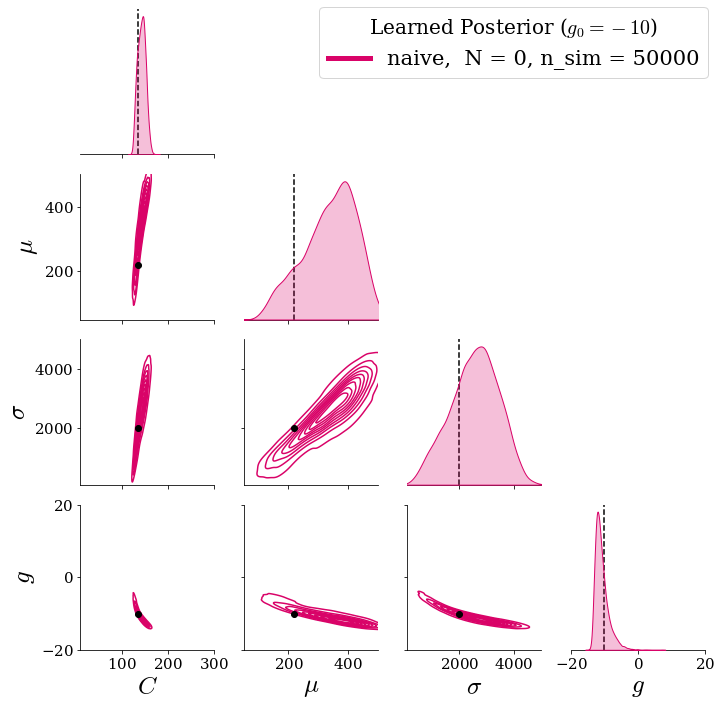

In [16]:
# Plot learned posteriors with true parameters 
cases = [{'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': GT_GAIN, 'n_sim': B,'single_rec': SINGLE_REC},]

posteriors = {}
context = {}
for exp in cases:
    filename_posterior = PATH_EXPERIMENT+f"posteriors_amortized/naive_posterior_nextra_{exp['n_extra']}_single_rec_{exp['single_rec']}_nsim_{exp['n_sim']}.pkl"
    filename_xobs = PATH_EXPERIMENT+f"gt_observations/nextra_{exp['n_extra']}/gt_observation_gain_{exp['gt_gain']}.pkl"
    if exp['n_extra'] > 0:
        filename_xobs = filename[:-4]+f"_single_rec_{exp['single_rec']}.pkl"
    
    label = f"{exp['method']},  N = {exp['n_extra']}, n_sim = 50000"
    posteriors[label]= torch.load(filename_posterior)
    context[label] = torch.load(filename_xobs)

color_dict = dict(zip(list(posteriors.keys()), ['#D90368', 'blue', '#FFA500']))

plot_pairgrid_with_groundtruth(
    posteriors=posteriors,
    context = context,
    theta_gt=list(theta_true.numpy()),
    color_dict=color_dict,
    handles=[
        plt.Line2D([], [], color=color_dict[label], linewidth=5, label=label) for label in list(posteriors.keys())
    ],
    n_samples=N_SAMPLES_POSTERIOR,
    title = r'Learned Posterior ($g_0=-10$)'
)


## Validation

### Dataset generation

In [17]:
# Simulate Data, create datasets
filename = PATH_EXPERIMENT + f"datasets_{METHOD}.pkl"

if os.path.exists(filename):
    datasets = torch.load(filename)
else:
    # b_theta, b_x = data_gen.get_joint_data(B)
    b_prime_theta, b_prime_x = simulate_for_sbi(
        simulator=simulator, proposal=prior, num_simulations=B_PRIME
    )
    b_prime_x = summary_extractor(b_prime_x)
    b_double_prime_theta, b_double_prime_x = simulate_for_sbi(
        simulator=simulator, proposal=prior, num_simulations=B_DOUBLE_PRIME
    )
    b_double_prime_x = summary_extractor(b_double_prime_x)

    datasets = {
        # "B": {"theta": b_theta, "x": b_x},
        "B_prime": {"theta": b_prime_theta, "x": b_prime_x},
        "B_double_prime": {"theta": b_double_prime_theta, "x": b_double_prime_x},
    }
    torch.save(datasets, filename)

datasets['B_prime']['theta'].shape, datasets['B_prime']['x'].shape
datasets['B_double_prime']['theta'] = datasets['B_double_prime']['theta'][:1000]
datasets['B_double_prime']['x'] = datasets['B_double_prime']['x'][:1000]

datasets['B_double_prime']['theta'].shape, datasets['B_double_prime']['x'].shape


(torch.Size([1000, 4]), torch.Size([1000, 33, 1]))

## Global COVERAGE: Expected PIT distribution for multivariate density NPEs
We show the global PIT-distribution for the JR-NMM NPE for which correlations play an important role. We can see that there is a problem with the $(\mu, \sigma)$ parameters (the estimator is biased). We will apply the 1D local coverage test [Zhao et al.] on each dimension to get more insight on the behavior of the estimator.

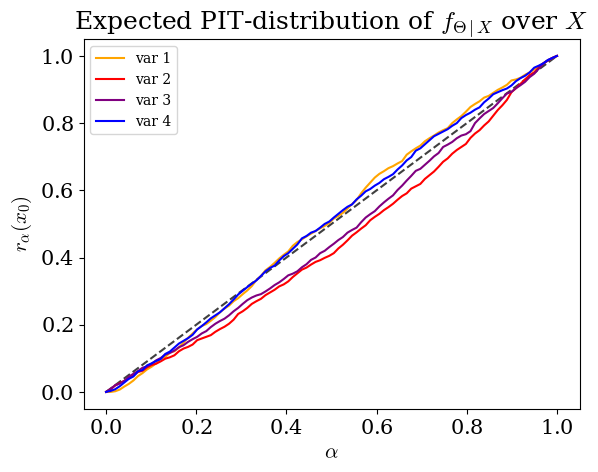

In [ ]:
# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators
theta_test, x_test = datasets['B_double_prime']['theta'], datasets['B_double_prime']['x']

# Compute PIT-values of the flows 
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)
flow_joint_pit_values = multi_cde_pit_values(
    theta_test, x_test, posterior, feature_transform=identity
)

# PP-plot of expected PIT-distribution for both flows
# alpha-quantiles = [P_X,Theta(Z < alpha)]
PP_plot_1D(
    PIT_values=[flow_joint_pit_values[0], flow_joint_pit_values[1], flow_joint_pit_values[2], flow_joint_pit_values[3]],
    alphas=np.linspace(0, 1, 100),
    colors=["orange", "red", "purple", "blue"],
    labels=["var 1", "var 2", "var 3", "var 4"],
    title=r"Expected PIT-distribution of $f_{\Theta \mid X}$ over $X$",
)

## LOCAL COVERAGE: Images for NeurIPS Workshop

## Choice of regression model


### 1. Comparison of Test Statistics under the null hypothesis

The goal is to find the best regressor $\hat{r}_{\alpha}(X)$ to estimate the local PIT values defined for $\alpha \in [0,1]$ by the c.d.f of the PIT at $X$:
$$ r_{\alpha}(X) = \mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; q_{\phi}) \leq \alpha) = \mathbb{E}[\mathbb{1}_{\{\text{PIT}(\Theta, X ; q_{\phi}) \leq \alpha\}}\mid X]$$

Under null hypothesis of local consistency at $x_0$, the PIT at $X=x_0$ follows a uniform distribution, i.e. we have 
$$H_0 : \big(q_{\phi}(\Theta \mid x_0) = p(\Theta \mid x_0) \big) \quad  \Rightarrow \quad  r_{\alpha}(x_0) = \alpha, \quad \forall \alpha \in [0,1].$$ 

The deviance from the null hypothesis is quantified by the test statistic: 
$$T_m(x_0) = \frac{1}{m}\sum_{t=1}^m (r_{\alpha_t}(x_0)-\alpha_t)^2.$$

A good regressor should be able to correctly represent the null hypothesis: it should predict the identity function for a locally consistent estimator (the test statistic should be 0):
$$q_{\phi}(\Theta \mid x_0) = p(\Theta \mid x_0)  \quad  \Rightarrow \quad  \hat{r}_{\alpha}(x_0) = \alpha, \forall \alpha \in [0,1] \quad  \Rightarrow \quad  \hat{T}_m(x_0) = 0$$


Theoretically for uniform PIT-values $U$, $\mathbb{P}(U \mid X) = U$. So for any $X=x_0$, we should get test statistics close to zero (not equal because we are in a finite sample regime). 

In practice, we can therefore compare regression methods by comparing test statistics obtained under the null hypothesis, i.e. for uniformly distributed PIT-values, on average over several trials:

For every trial: 
- generate $U_i \sim \mathcal{U}(0,1)$ 
- regress $U_i$ on $X_i$ to learn $\hat{r}_{\alpha}(X)$ under $H_0$
- compute the test statistic for any $X=x_0$ 

Compute the average test statistic over all trials. (and for several $x_0$?)




In [67]:
# load the histgradboost regressors trained on uniform PIT values (100 trials) and evaluated on 21 alpha values

path_lct_max_iter = PATH_EXPERIMENT + f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain_no_stochasticity/max_iter_exp/lct_results_sample50_histgrad90_"

gain_list = np.linspace(-20,20,9,dtype=int)
max_iter_list = np.linspace(10,200,20,dtype=int)
test_stats_dict = {}
for g in gain_list:
    test_stats_dict[g] = {}
    for i in range(1,5):
        test_stats_dict[g][f'dim_{i}'] = {}
        test_stats_mean ={}
        test_stats_std = {}
        for it in max_iter_list:
            lct_max_iter_path_g = path_lct_max_iter + f"maxiter_{it}_ntrials_100_n_alphas_21_gain_{g}.pkl"

            r_alpha_null_list_g = torch.load(lct_max_iter_path_g)['r_alpha_null_list']
            n_trials = len(r_alpha_null_list_g)
            T_values = []
            for t in range(n_trials):
                T_values.append(compute_test_statistic(r_alpha_null_list_g[t][f'dim_{i}']))
            test_stats_mean[it] = np.mean(T_values)
            test_stats_std[it] = np.std(T_values)
        test_stats_dict[g][f'dim_{i}']['mean'] = pd.Series(test_stats_mean)
        test_stats_dict[g][f'dim_{i}']['std'] = pd.Series(test_stats_std)

T_dim ={}  
for i in range(1,5):
    T_dim[f'dim_{i}'] = {}
    T_dim[f'dim_{i}']['mean'] = {}
    T_dim[f'dim_{i}']['std'] = {}
    for it in max_iter_list:
        T_i_it = []
        for g in gain_list:
            T_i_it.append(test_stats_dict[g][f'dim_{i}']['mean'][it])
        T_dim[f'dim_{i}']['mean'][it] = np.mean(T_i_it)
        T_dim[f'dim_{i}']['std'][it] = np.std(T_i_it)
    T_dim[f'dim_{i}']['mean'] = pd.Series(T_dim[f'dim_{i}']['mean'])
    T_dim[f'dim_{i}']['std'] = pd.Series(T_dim[f'dim_{i}']['std'])

In [68]:
# load the baseline regressors trained on uniform PIT values (100 trials and 21 alpha values)
path_lct = PATH_EXPERIMENT+f'lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain_no_stochasticity/'
path_lct_baseline = path_lct+f'baseline/lct_results_baseline_mlp_nalpha_21_ntrials_100_n_alphas_21'

T_null_base = []
for gain in gain_list:
    path_lct_baseline_g0 = path_lct_baseline+f'_gain_{gain}.pkl'

    r_alpha_null_list_base_g0 = torch.load(path_lct_baseline_g0)['r_alpha_null_list']
    n_trials = len(r_alpha_null_list_base_g0)
    T_base_t100_na21_mean = 0
    for i in range(1,5):
        T_base_t100_na21 = []
        for t in range(n_trials):
            T_base_t100_na21.append(compute_test_statistic(r_alpha_null_list_base_g0[t][f'dim_{i}']))
        T_base_t100_na21_mean += np.mean(T_base_t100_na21)
    T_base_t100_na21_mean /=4
    T_null_base.append(T_base_t100_na21_mean)
print(np.mean(T_null_base), np.std(T_null_base))

0.0015458306516508678 0.0009378333532686699


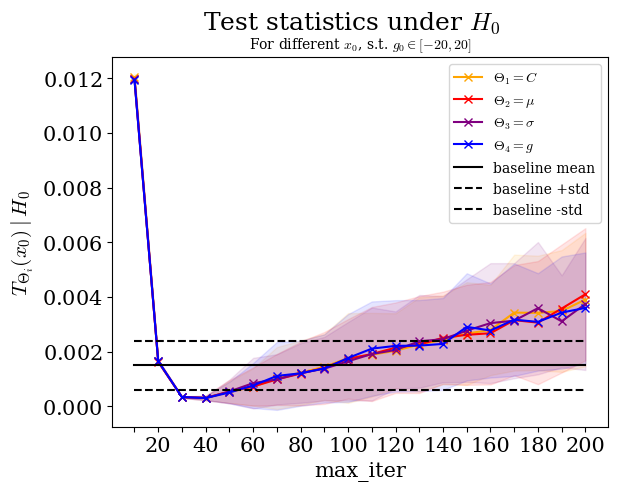

In [74]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

colors=["orange", "red", "purple", "blue"]
labels = [r'$\Theta_1 = C$', r'$\Theta_2 = \mu$', r'$\Theta_3 = \sigma$', r'$\Theta_4 = g$']

xticks =[]
for it in range(1,11):
    xticks+=['',str(it*20)]

for i in range(1,5):
    T_dim[f'dim_{i}']['mean'].plot(marker='x', label=labels[i-1], color=colors[i-1])
    error = T_dim[f'dim_{i}']['std']
    y = T_dim[f'dim_{i}']['mean']
    plt.fill_between(max_iter_list, y-error, y+error, color=colors[i-1], alpha=0.1)

plt.plot(max_iter_list, [0.0015]*len(max_iter_list), color='black', label='baseline mean')
plt.plot(max_iter_list, [0.0015-0.0009]*len(max_iter_list), '--', color='black', label='baseline +std')
plt.plot(max_iter_list, [0.0015+0.0009]*len(max_iter_list), '--', color='black', label='baseline -std')
plt.legend()
plt.xticks(np.linspace(10,200,20), xticks)
plt.xlabel('max_iter', fontsize=15)
plt.ylabel(r'$T_{\Theta_i}(x_0) \mid H_0$', fontsize=15)
plt.suptitle(r'Test statistics under $H_0$', fontsize=18)
plt.title(r'For different $x_0$, s.t. $g_0 \in [-20,20]$', fontsize=10)
plt.show()

Valid `max_iter` values for our `HistGradBoostClassifier` with default parameters go from 30 to 90. They that give lower test statistics under the null than the baseline.

Intuitively we could say that amongst the regressors that outperform the baseline under the null, the best one is the one with the highest number of iterations. It will probably be better at estimating PIT values for complex data distributions that are not calibrated.

### 2. Recovery of the true Expected PIT 

We will now compare the baseline method and these selected HG-regressors in terms of recovery of the true PIT values of our flow on an evaluation dataset of the joint $\{(\Theta_i, X_i), i=1,\dots, n_{eval}\}$.

The estimated local PIT values are:
$$\hat{r}_{\alpha}(X) \approx \mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; q_{\phi}) \leq \alpha) = \mathbb{E}[\mathbb{1}_{\{\text{PIT}(\Theta, X ; q_{\phi}) \leq \alpha\}}\mid X]$$

We can compute the expected estimated PIT values over the evaluation dataset and compare them to the real expected PIT values:

$$\hat{E}(\alpha) = \frac{1}{n_{eval}} \sum_{i=1}^{n_{eval}} \hat{r}_{\alpha}(X_i) \quad \text{vs.} \quad E(\alpha) = \frac{1}{n_{eval}}\sum_{i=1}^{n_{eval}} \mathbb{1}_{\{\text{PIT}(\Theta_i, X_i ; q_{\phi}) \leq \alpha\}}$$

We do this by computing the MSE over a grid of alpha values `np.linspace(0,0.99,m)` (with `m=100`):

$$ \frac{1}{m}\sum_{t=1}^{m} (\hat{E}(\alpha_t) - E(\alpha_t))^2$$

We compute the mean and std over 10 models per regression method.

In [19]:
# TRUE EXPECTED PIT-DISTRIBUTION of the trained estimators
theta_test, x_test = datasets['B_double_prime']['theta'], datasets['B_double_prime']['x']

# Compute PIT-values of the flows 
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)
flow_joint_pit_values = multi_cde_pit_values(
    theta_test, x_test, posterior, feature_transform=identity
)

In [44]:
from diagnostics.pp_plots import PP_vals

nb_classifiers = 10
method_names = ['baseline', 'hg30', 'hg40', 'hg50', 'hg60', 'hg70', 'hg80', 'hg90']

euc_dist_list = {}
for method_name in method_names:
    euc_dist_list[method_name] = {}
    # Load Estimated Expected PIT values 
    E_hat_loaded = torch.load(f'saved_experiments/JR-NMM/reg_eval/expected_pit_list_{method_name}.pkl')

    alphas = np.linspace(0,0.99,100)

    for i in range(1,5):
        # True Expected PIT values 
        E = PP_vals(flow_joint_pit_values[i-1], alphas)
        euc_dist_list[method_name][f'dim_{i}'] = {}
        euc_dist_list_c =[]
        for c in range(nb_classifiers):
            euc_dist_list_c.append(np.mean((E_hat_loaded[c][f'dim_{i}'] - E)**2))

        euc_dist_list[method_name][f'dim_{i}']['mean'] = np.mean(euc_dist_list_c)
        euc_dist_list[method_name][f'dim_{i}']['std'] = np.std(euc_dist_list_c)
        euc_dist_list[method_name][f'dim_{i}'] = pd.Series(euc_dist_list[method_name][f'dim_{i}'])

In [45]:
pd.DataFrame(euc_dist_list)

baseline  \
dim_1  mean    2.690352
std     0.010925
dtype: float64   
dim_2  mean    2.892275
std     0.011574
dtype: float64   
dim_3  mean    2.836735
std     0.011433
dtype: float64   
dim_4  mean    2.711284
std     0.011006
dtype: float64   

                                                   hg30  \
dim_1  mean    2.594158
std     0.005112
dtype: float64   
dim_2  mean    2.794360
std     0.005413
dtype: float64   
dim_3  mean    2.739195
std     0.005341
dtype: float64   
dim_4  mean    2.614549
std     0.005148
dtype: float64   

                                                   hg40  \
dim_1  mean    2.641029
std     0.002234
dtype: float64   
dim_2  mean    2.842273
std     0.002374
dtype: float64   
dim_3  mean    2.786937
std     0.002328
dtype: float64   
dim_4  mean    2.661812
std     0.002226
dtype: float64   

                                                   hg50  \
dim_1  mean    2.660155
std     0.005023
dtype: float64   
dim_2  mean    2.861810
std     0.005234
dtype: float64   
dim_3  mean    2.806414
std     0.005170
dtype: float64   
dim_4  mean    2.681080
std     0.005048
dtype: float64   

                                                   hg60  \
dim_1    mean    2.66725
std     0.00420
dtype: float64   
dim_2  mean    2.869131
std     0.004433
dtype: float64   
dim_3  mean    2.813701
std     0.004360
dtype: float64   
dim_4  mean    2.688322
std     0.004202
dtype: float64   

                                                   hg70  \
dim_1  mean    2.670083
std     0.002258
dtype: float64   
dim_2  mean    2.871897
std     0.002363
dtype: float64   
dim_3  mean    2.816466
std     0.002353
dtype: float64   
dim_4  mean    2.691199
std     0.002300
dtype: float64   

                                                   hg80  \
dim_1  mean    2.673418
std     0.004413
dtype: float64   
dim_2  mean    2.875313
std     0.004653
dtype: float64   
dim_3  mean    2.819878
std     0.004573
dtype: float64   
dim_4  mean    2.694554
std     0.004433
dtype: float64   

                                                   hg90  
dim_1  mean    2.674397
std     0.005622
dtype: float64  
dim_2  mean    2.876363
std     0.005917
dtype: float64  
dim_3  mean    2.820897
std     0.005815
dtype: float64  
dim_4  mean    2.695554
std     0.005646
dtype: float64

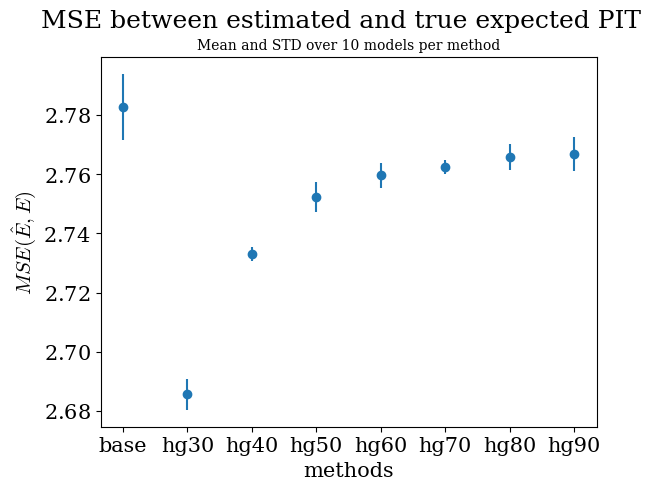

In [81]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'
method_names = ['baseline', 'hg30', 'hg40', 'hg50', 'hg60', 'hg70', 'hg80', 'hg90']

means = [np.mean([euc_dist_list[method_name][f'dim_{i}']['mean'] for i in range(1,5)]) for method_name in method_names]
stds = [np.mean([euc_dist_list[method_name][f'dim_{i}']['std'] for i in range(1,5)]) for method_name in method_names]
xticks = ['base']+method_names[1:]
plt.errorbar(list(range(len(method_names))), means, yerr=stds, fmt='o', linestyle='')
plt.xticks(list(range(len(method_names))), xticks)
plt.suptitle('MSE between estimated and true expected PIT', fontsize=18)
plt.title('Mean and STD over 10 models per method',fontsize=10)
plt.xlabel('methods', fontsize=15)
plt.ylabel(r'$MSE(\hat{E}, E)$', fontsize=15)
plt.show()

All HG-methods are better than the baseline (lower MSE and less variance).

We will choose hg40 or hg70 (lowest variance which is important for p-value computation).

### Image 2: Multi PIT LCT p-values for different $x_0$

#### Option 1 : Along the 1D gain parameter space 

##### Generate test observations $x_0$ 

In [30]:
# ground-truth parameters to generate observation
# fixed_params
c = 135.0
mu = 220.0 
sigma = 2000.0
# different gain values 
# gain_list = np.linspace(-25,25,11)
gain_list = np.linspace(-22.5,22.5,10)

theta_true_list = []

x_obs_list = []
for g in gain_list:
    theta_true = torch.FloatTensor([135.0, 220.0, 2000.0, g])
    meta_parameters['theta'] = theta_true
    theta_true_list.append(theta_true)

    ground_truth = get_ground_truth(meta_parameters,
                                input_parameters=['C', 'mu', 'sigma', 'gain'],
                                p_gain=prior, single_recording=SINGLE_REC)
    ground_truth['observation'] = summary_extractor(ground_truth['observation'])
    x_obs = ground_truth['observation'] # torch.Size([1, 33, n_extra+1])
    x_obs_list.append(x_obs)
# torch.save([theta_true, torch.stack(x_obs_list)[:,0,:,:]], PATH_EXPERIMENT+'gt_observations/nextra_0/additional_gain_experiment_new.pkl')

x_obs = torch.load(PATH_EXPERIMENT+'gt_observations/nextra_0/gain_experiment_new.pkl')[1]
# x_obs_add = torch.load(PATH_EXPERIMENT+'gt_observations/nextra_0/additional_gain_experiment_new.pkl')[1]


/data/parietal/store/work/jlinhart/git_repos/valDiags_flows/hnpe/simulator.py:140: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/torch/csrc/utils/tensor_new.cpp:198.)
  x = theta.new(x).unsqueeze(-1)


In [35]:
path_lct = PATH_EXPERIMENT + f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain/"
path_lct_hg_t100_na21 = (
    path_lct + f"lct_results_sample50_histgrad90_ntrials_{100}_n_alphas_{21}"
)  # with pvalues, used to compare to baseline
path_lct_hg_t1000_na21 = (
    path_lct + f"lct_results_sample50_histgrad90_ntrials_{1000}_n_alphas_{21}"
)  # more trials for pvalues, not available for baseline
path_lct_hg_t1000_na100 = (
    path_lct + f"lct_results_sample50_histgrad90_ntrials_{1000}_n_alphas_{100}"
)  # more trials for pvalues nd more alpha values, not available for baseline
path_lct_base_t100_na21 = (
    path_lct + f"lct_results_baseline_mlp_nalpha_21_ntrials_{100}_n_alphas_{21}"
)  # with pvalues
path_lct_base_t1000_na100 = (
    path_lct + f"lct_results_baseline_mlp_nalpha_100_ntrials_{1000}_n_alphas_{100}"
)  # no pvalues, used to plot pp-pplot

gain_list = np.linspace(-20, 20, 9, dtype=int)

lct_hg_t100_na21_path_list = []
lct_hg_t1000_na21_path_list = []
lct_hg_t1000_na100_path_list = []
lct_base_t100_na21_path_list = []
lct_base_t1000_na100_path_list = []

for g, x in zip(gain_list, x_obs[1:10][:, :]):
    lct_hg_t100_na21_path_list.append(path_lct_hg_t100_na21 + f"_gain_{g}.pkl")
    lct_hg_t1000_na21_path_list.append(path_lct_hg_t1000_na21 + f"_gain_{g}.pkl")
    lct_hg_t1000_na100_path_list.append(path_lct_hg_t1000_na100 + f"_gain_{g}.pkl")
    lct_base_t100_na21_path_list.append(path_lct_base_t100_na21 + f"_gain_{g}.pkl")
    lct_base_t1000_na100_path_list.append(path_lct_base_t1000_na100 + f"_gain_{g}.pkl")


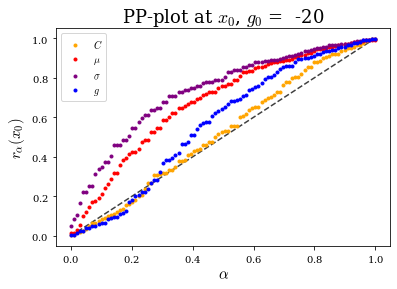

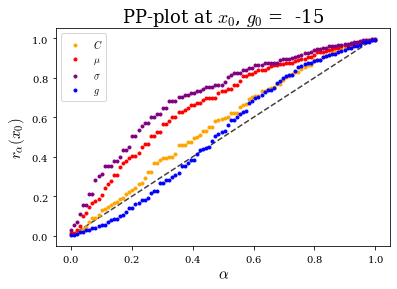

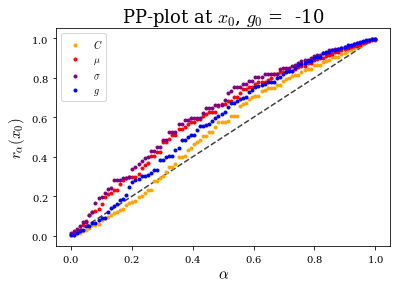

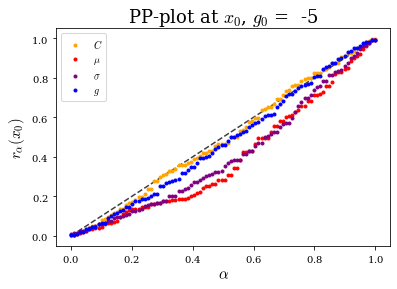

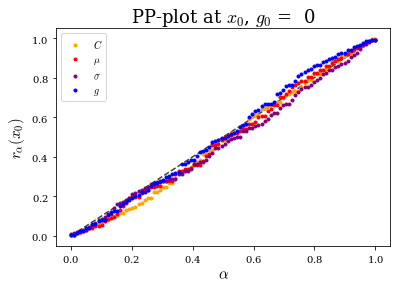

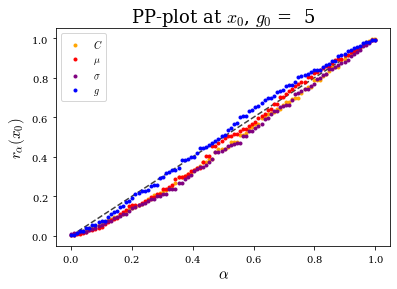

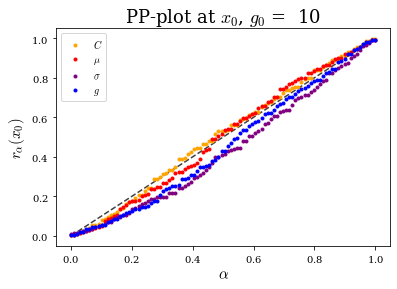

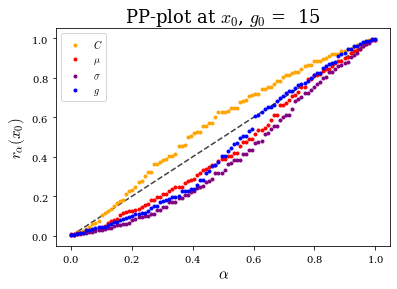

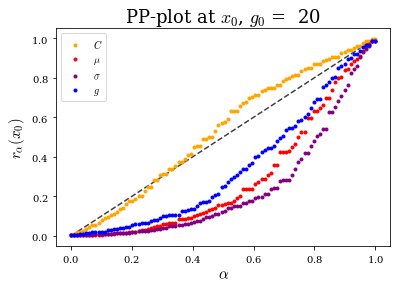

In [11]:
from diagnostics.pp_plots import multi_pp_plots
x_eval_names = [r', $g_0$ = '+f' {g}' for g in gain_list]
param_names = [r'$C$ ', r'$\mu$ ', r'$\sigma$ ', r'$g$ ']
multi_pp_plots([lct_hg_t1000_na100_path_list] , x_eval_names, param_names,pvalues=False)

##### Plot Test Statistic

In [36]:
from diagnostics.multi_local_test import get_lct_results
df_hg_t1000_na100 = get_lct_results(lct_hg_t1000_na100_path_list)
df_hg_t1000_na100.columns = df_hg_t1000_na100.columns.str.split('__', expand=True)
df_hg_t1000_na100.index = gain_list

df_base_na100 = get_lct_results(lct_base_t1000_na100_path_list, pvalues=False)
df_base_na100.index = gain_list

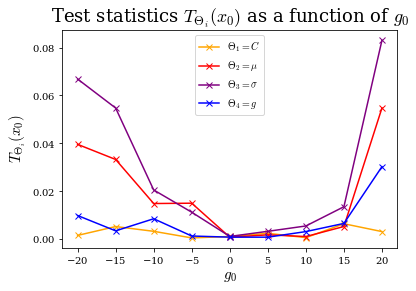

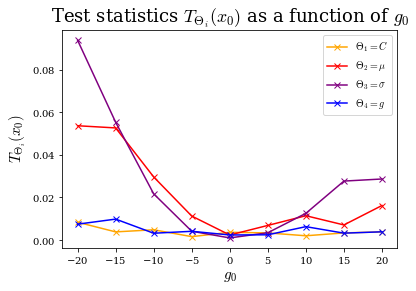

In [37]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

colors=["orange", "red", "purple", "blue"]
labels = [r'$\Theta_1 = C$', r'$\Theta_2 = \mu$', r'$\Theta_3 = \sigma$', r'$\Theta_4 = g$']

for i in range(1,5):
    plt.plot(df_hg_t1000_na100['test_stats'][f'dim_{i}'], marker='x', label=labels[i-1], color=colors[i-1])
plt.legend()
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$T_{\Theta_i}(x_0)$', fontsize=15)
plt.title(r'Test statistics $T_{\Theta_i}(x_0)$ as a function of $g_0$', fontsize=18)
plt.show()
plt.show()

for i in range(1,5):
    plt.plot(df_base_na100[f'dim_{i}'], marker='x', label=labels[i-1], color=colors[i-1])
plt.legend()
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$T_{\Theta_i}(x_0)$', fontsize=15)
plt.title(r'Test statistics $T_{\Theta_i}(x_0)$ as a function of $g_0$', fontsize=18)
plt.show()
plt.show()

##### Plot p-values

In [40]:
df_hg_t1000_na21 = get_lct_results(lct_hg_t1000_na21_path_list)
df_hg_t1000_na21.columns = df_hg_t1000_na21.columns.str.split('__', expand=True)
df_hg_t1000_na21.index = gain_list

df_hg_t100_na21 = get_lct_results(lct_hg_t100_na21_path_list)
df_hg_t100_na21.columns = df_hg_t100_na21.columns.str.split('__', expand=True)
df_hg_t100_na21.index = gain_list

df_base_t100_na21 = get_lct_results(lct_base_t100_na21_path_list)
df_base_t100_na21.columns = df_base_t100_na21.columns.str.split('__', expand=True)
df_base_t100_na21.index = gain_list

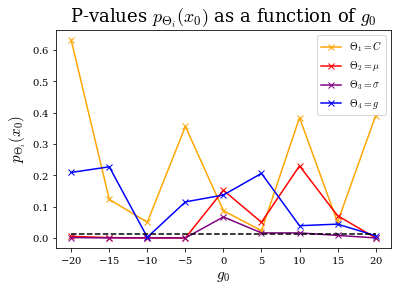

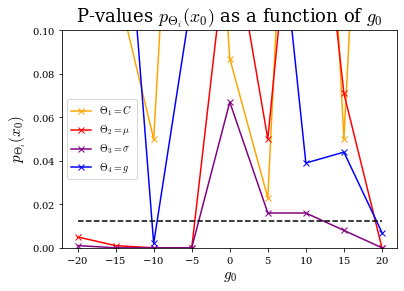

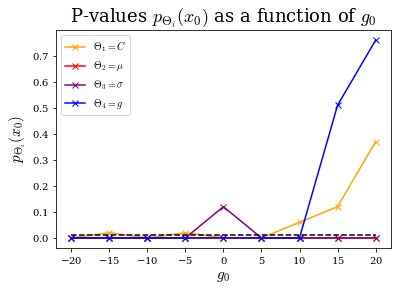

In [41]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

from diagnostics.multi_local_test import compute_test_statistic

colors=["orange", "red", "purple", "blue"]
labels = [r'$\Theta_1 = C$', r'$\Theta_2 = \mu$', r'$\Theta_3 = \sigma$', r'$\Theta_4 = g$']

gain_list = np.linspace(-20,20,9)

# HISTGRAD 
for i in range(1,5):
    plt.plot(gain_list, df_hg_t1000_na21['p_values'][f'dim_{i}'], marker='x', label=labels[i-1], color=colors[i-1])
plt.legend()
plt.plot(gain_list,np.ones_like(gain_list)*0.0125, '--', color='black')
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$p_{\Theta_i}(x_0)$', fontsize=15)
plt.title(r'P-values $p_{\Theta_i}(x_0)$ as a function of $g_0$', fontsize=18)
plt.show()

# Zoom
for i in range(1,5):
    plt.plot(gain_list, df_hg_t1000_na21['p_values'][f'dim_{i}'], marker='x', label=labels[i-1], color=colors[i-1])
plt.legend()
plt.plot(gain_list,np.ones_like(gain_list)*0.0125, '--', color='black')
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylim(0,0.1)
plt.ylabel(r'$p_{\Theta_i}(x_0)$', fontsize=15)
plt.title(r'P-values $p_{\Theta_i}(x_0)$ as a function of $g_0$', fontsize=18)
plt.show()

# BASELINE
for i in range(1,5):
    plt.plot(gain_list, df_base_t100_na21['p_values'][f'dim_{i}'], marker='x', label=labels[i-1], color=colors[i-1])
plt.plot(gain_list,np.ones_like(gain_list)*0.0125, '--', color='black')
plt.legend()
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$p_{\Theta_i}(x_0)$', fontsize=15)
plt.title(r'P-values $p_{\Theta_i}(x_0)$ as a function of $g_0$', fontsize=18)
plt.show()


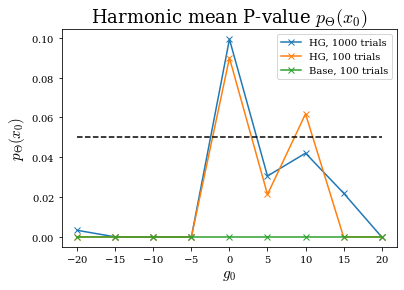

In [42]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

gain_list = np.linspace(-20,20,9)

# HISTGRAD 
plt.plot(gain_list, df_hg_t1000_na21['p_values']['hmean'], marker='x', label='HG, 1000 trials')
plt.plot(gain_list, df_hg_t100_na21['p_values']['hmean'], marker='x', label='HG, 100 trials')
plt.plot(gain_list, df_base_t100_na21['p_values'][f'hmean'], marker='x', label='Base, 100 trials')
plt.legend()
plt.plot(gain_list,np.ones_like(gain_list)*0.05, '--', color='black')
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$p_{\Theta}(x_0)$', fontsize=15)
plt.title(r'Harmonic mean P-value $p_{\Theta}(x_0)$', fontsize=18)
plt.show()

##### Plot Multi-Test results (not hmean)

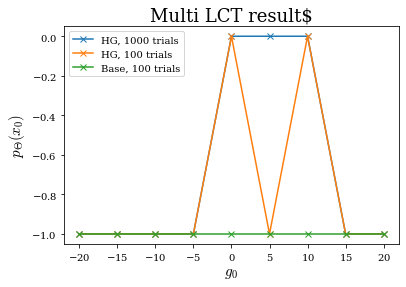

In [43]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

gain_list = np.linspace(-20,20,9)

# HISTGRAD 
plt.plot(gain_list, df_hg_t1000_na21['lct_results']['combined']*-1, marker='x', label='HG, 1000 trials')
plt.plot(gain_list, df_hg_t100_na21['lct_results']['combined']*-1, marker='x', label='HG, 100 trials')
plt.plot(gain_list, df_base_t100_na21['lct_results']['combined']*-1, marker='x', label='Base, 100 trials')
plt.legend()
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$p_{\Theta}(x_0)$', fontsize=15)
plt.title(r'Multi LCT result$', fontsize=18)
plt.show()

#### No stochasiticity: multiply by gain

In [74]:
# ground-truth parameters to generate observation
# fixed_params
c = 135.0
mu = 220.0 
sigma = 2000.0
# different gain values 
gain_list = np.linspace(-20,20,9, dtype=int)

theta_true = torch.FloatTensor([135.0, 220.0, 2000.0, 0])
meta_parameters['theta'] = theta_true

ground_truth = get_ground_truth(meta_parameters,
                            input_parameters=['C', 'mu', 'sigma', 'gain'],
                            p_gain=prior, single_recording=SINGLE_REC)
# ground_truth['observation'] = summary_extractor(ground_truth['observation'])
x_obs = ground_truth['observation'] 

x_obs_list = []
for g in gain_list:
    x_obs_g = x_obs*(10**(g/10))
    x_obs_g = summary_extractor(x_obs_g) # torch.Size([1, 33, n_extra+1])
    x_obs_list.append(x_obs_g)
# torch.save(torch.stack(x_obs_list)[:,0,:,:], PATH_EXPERIMENT+'gt_observations/nextra_0/gain_experiment_no_stoch.pkl')

x_obs_list = torch.load(PATH_EXPERIMENT+'gt_observations/nextra_0/gain_experiment_no_stoch.pkl')

In [60]:
path_lct = PATH_EXPERIMENT + f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain_no_stochasticity/"
path_lct_hg_t100_na21_ns = (
    path_lct + f"lct_results_sample50_histgrad90_ntrials_{100}_n_alphas_{21}"
)  # with pvalues, used to compare to baseline
path_lct_hg_t1000_na21_ns = (
    path_lct + f"lct_results_sample50_histgrad90_ntrials_{1000}_n_alphas_{21}"
)  # more trials for pvalues, not available for baseline

path_lct_hg_t1000_na100_ns = (
    path_lct + f"lct_results_sample50_histgrad90_ntrials_{1000}_n_alphas_{100}"
)  # more trials for pvalues nd more alpha values, not available for baseline

path_lct_hg_t100_na21_ns_nm = (
    path_lct + f"lct_results_sample50_histgrad90_no_monoton_ntrials_{100}_n_alphas_{21}"
)  # with pvalues, used to compare to baseline
path_lct_hg_t1000_na21_ns_nm = (
    path_lct + f"lct_results_sample50_histgrad90_no_monoton_ntrials_{1000}_n_alphas_{21}"
)  # more trials for pvalues, not available for baseline
path_lct_hg_t1000_na100_ns_nm = (
    path_lct + f"lct_results_sample50_histgrad90_no_monoton_ntrials_{1000}_n_alphas_{100}"
)  # more trials for pvalues nd more alpha values, not available for baseline

path_lct_base_t100_na21_ns = (
    path_lct + f"lct_results_baseline_mlp_nalpha_21_ntrials_{100}_n_alphas_{21}"
)  # with pvalues
path_lct_base_t1000_na100_ns = (
    path_lct + f"lct_results_baseline_mlp_nalpha_100_ntrials_{1000}_n_alphas_{100}"
)  # no pvalues, used to plot pp-pplot


gain_list = np.linspace(-20, 20, 9, dtype=int)

lct_hg_t100_na21_path_list_ns = []
lct_hg_t1000_na21_path_list_ns = []
lct_hg_t1000_na100_path_list_ns = []
lct_hg_t100_na21_path_list_ns_nm = []
lct_hg_t1000_na21_path_list_ns_nm = []
lct_hg_t1000_na100_path_list_ns_nm = []
lct_base_t100_na21_path_list_ns = []
lct_base_t1000_na100_path_list_ns = []


for g, x in zip(gain_list, x_obs_list[:, :]):
    lct_hg_t100_na21_path_list_ns.append(path_lct_hg_t100_na21_ns + f"_gain_{g}.pkl")
    lct_hg_t1000_na21_path_list_ns.append(path_lct_hg_t1000_na21_ns + f"_gain_{g}.pkl")
    lct_hg_t1000_na100_path_list_ns.append(path_lct_hg_t1000_na100_ns + f"_gain_{g}.pkl")
    lct_hg_t100_na21_path_list_ns_nm.append(path_lct_hg_t100_na21_ns_nm + f"_gain_{g}.pkl")
    lct_hg_t1000_na21_path_list_ns_nm.append(path_lct_hg_t1000_na21_ns_nm + f"_gain_{g}.pkl")
    lct_hg_t1000_na100_path_list_ns_nm.append(path_lct_hg_t1000_na100_ns_nm + f"_gain_{g}.pkl")
    lct_base_t100_na21_path_list_ns.append(path_lct_base_t100_na21_ns + f"_gain_{g}.pkl")
    lct_base_t1000_na100_path_list_ns.append(path_lct_base_t1000_na100_ns + f"_gain_{g}.pkl")
    


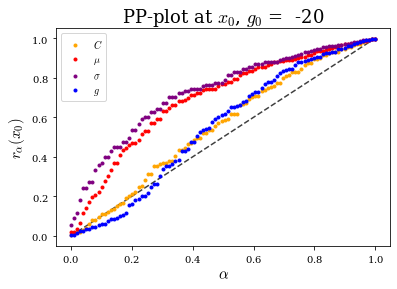

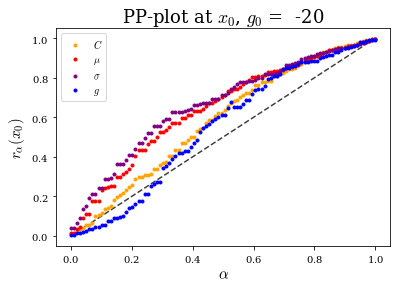

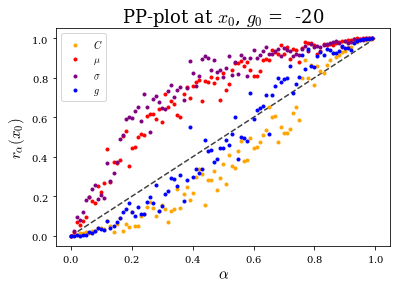

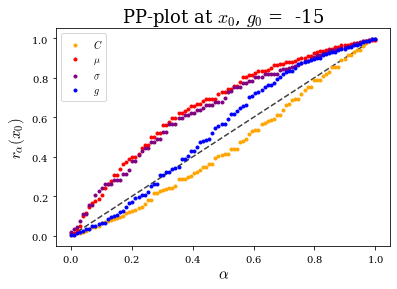

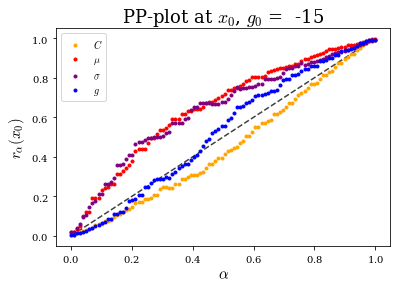

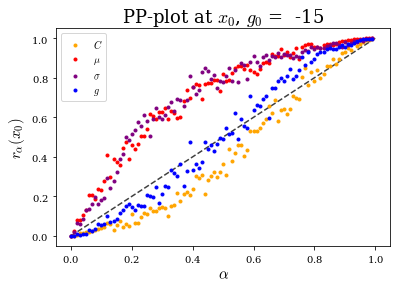

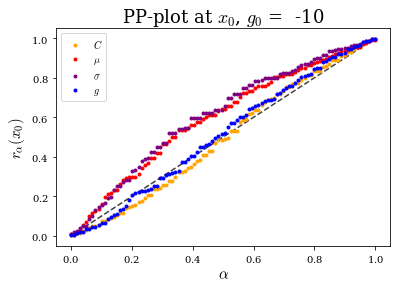

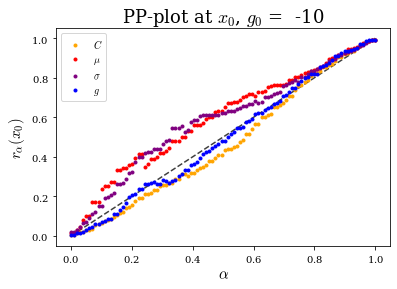

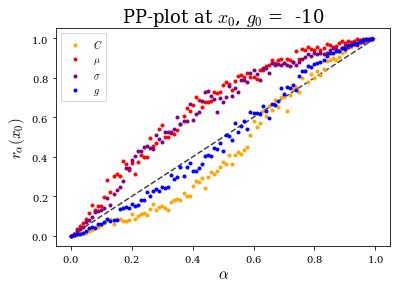

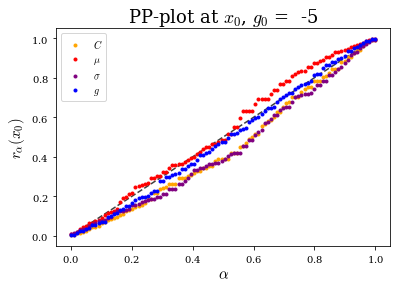

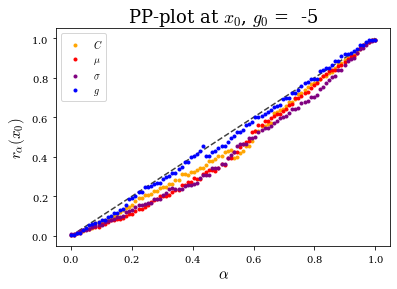

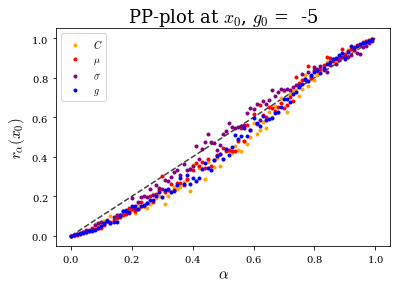

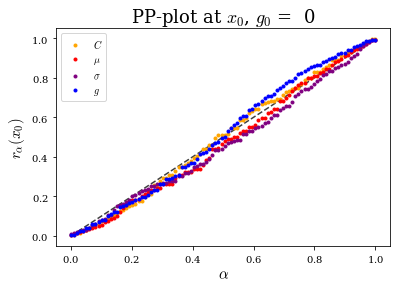

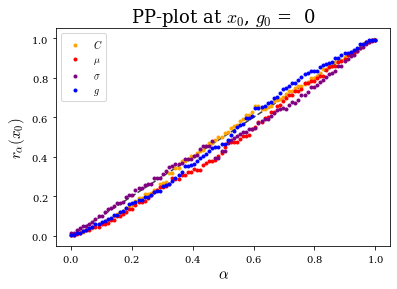

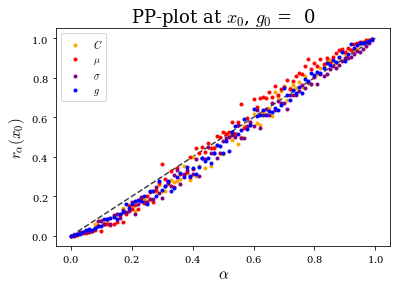

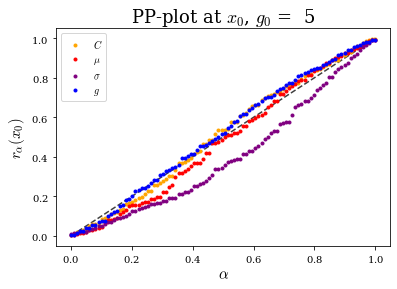

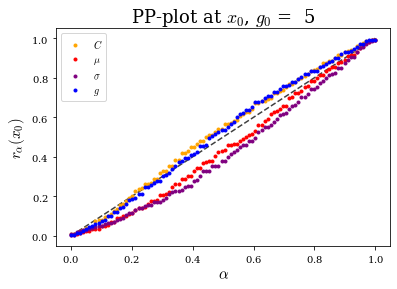

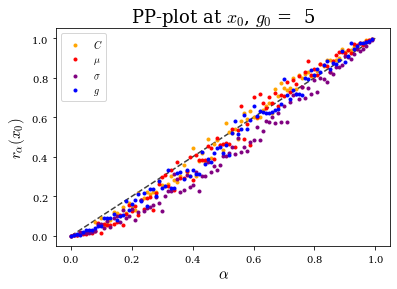

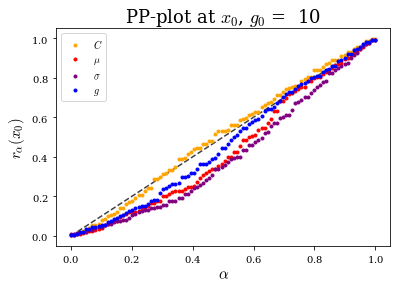

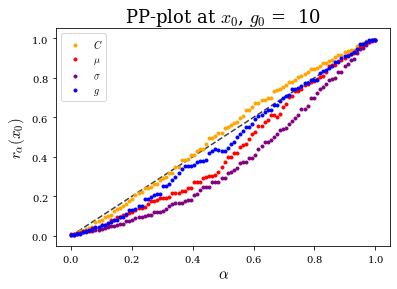

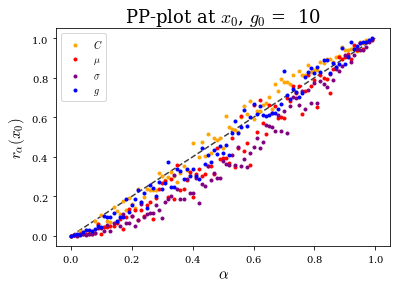

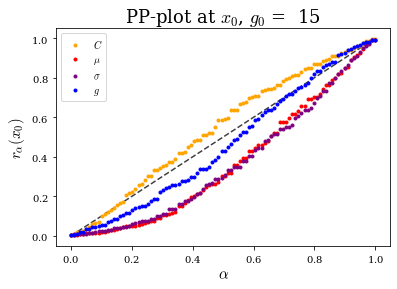

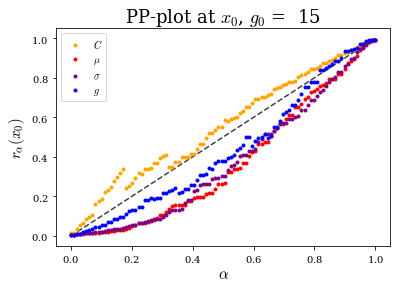

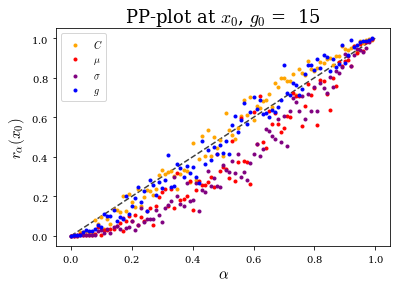

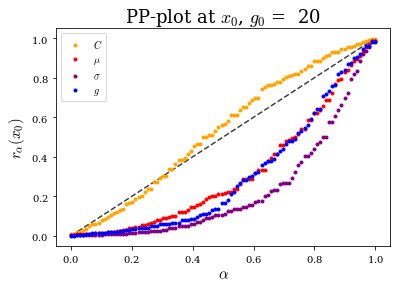

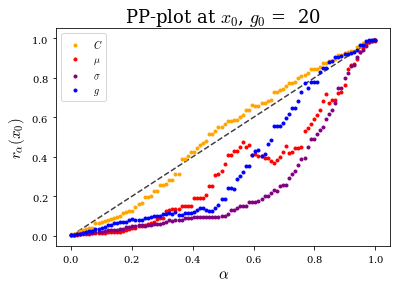

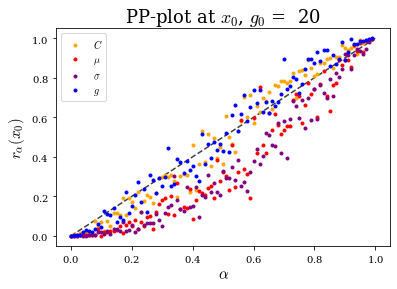

In [61]:
from diagnostics.pp_plots import multi_pp_plots
x_eval_names = [r', $g_0$ = '+f' {g}' for g in gain_list]
param_names = [r'$C$ ', r'$\mu$ ', r'$\sigma$ ', r'$g$ ']
multi_pp_plots([lct_hg_t1000_na100_path_list_ns, lct_hg_t1000_na100_path_list_ns_nm, lct_base_t1000_na100_path_list_ns] , x_eval_names, param_names,pvalues=False)

##### Plot Test Statistic

In [32]:
from diagnostics.multi_local_test import get_lct_results
df_hg_t1000_na100_ns = get_lct_results(lct_hg_t1000_na100_path_list_ns, pvalues=False)
# df_hg_t1000_na100_ns.columns = df_hg_t1000_na100_ns.columns.str.split('__', expand=True)
df_hg_t1000_na100_ns.index = gain_list

df_hg_t1000_na100_ns_nm = get_lct_results(lct_hg_t1000_na100_path_list_ns_nm, pvalues=False)
# df_hg_t1000_na100_ns_nm.columns = df_hg_t1000_na100_ns_nm.columns.str.split('__', expand=True)
df_hg_t1000_na100_ns_nm.index = gain_list

df_base_na100_ns = get_lct_results(lct_base_t1000_na100_path_list_ns, pvalues=False)
df_base_na100_ns.index = gain_list

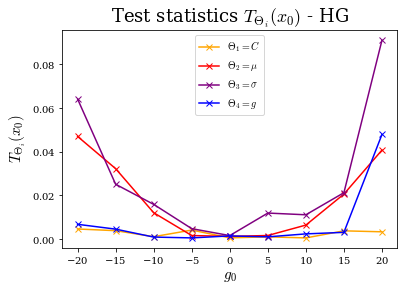

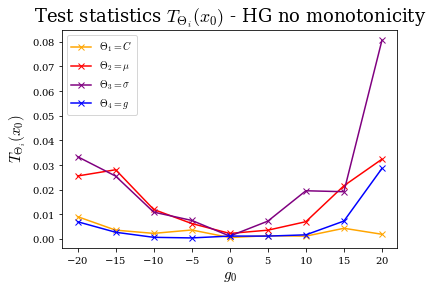

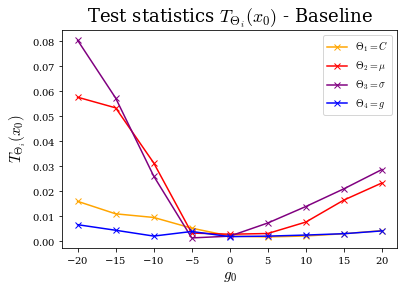

In [46]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

colors=["orange", "red", "purple", "blue"]
labels = [r'$\Theta_1 = C$', r'$\Theta_2 = \mu$', r'$\Theta_3 = \sigma$', r'$\Theta_4 = g$']

for i in range(1,5):
    plt.plot(df_hg_t1000_na100_ns[f'dim_{i}'], marker='x', label=labels[i-1], color=colors[i-1])
plt.legend()
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$T_{\Theta_i}(x_0)$', fontsize=15)
plt.title(r'Test statistics $T_{\Theta_i}(x_0)$ - HG', fontsize=18)
plt.show()
plt.show()

for i in range(1,5):
    plt.plot(df_hg_t1000_na100_ns_nm[f'dim_{i}'], marker='x', label=labels[i-1], color=colors[i-1])
plt.legend()
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$T_{\Theta_i}(x_0)$', fontsize=15)
plt.title(r'Test statistics $T_{\Theta_i}(x_0)$ - HG no monotonicity', fontsize=18)
plt.show()
plt.show()

for i in range(1,5):
    plt.plot(df_base_na100_ns[f'dim_{i}'], marker='x', label=labels[i-1], color=colors[i-1])
plt.legend()
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$T_{\Theta_i}(x_0)$', fontsize=15)
plt.title(r'Test statistics $T_{\Theta_i}(x_0)$ - Baseline', fontsize=18)
plt.show()
plt.show()

##### Plot p-values

In [44]:
df_hg_t1000_na21_ns = get_lct_results(lct_hg_t1000_na21_path_list_ns)
df_hg_t1000_na21_ns.columns = df_hg_t1000_na21_ns.columns.str.split('__', expand=True)
df_hg_t1000_na21_ns.index = gain_list

# df_hg_t1000_na21_ns_nm = get_lct_results(lct_hg_t1000_na21_path_list_ns_nm)
# df_hg_t1000_na21_ns_nm.columns = df_hg_t1000_na21_ns_nm.columns.str.split('__', expand=True)
# df_hg_t1000_na21_ns_nm.index = gain_list

df_hg_t100_na21_ns = get_lct_results(lct_hg_t100_na21_path_list_ns)
df_hg_t100_na21_ns.columns = df_hg_t100_na21_ns.columns.str.split('__', expand=True)
df_hg_t100_na21_ns.index = gain_list

df_hg_t100_na21_ns_nm = get_lct_results(lct_hg_t100_na21_path_list_ns_nm)
df_hg_t100_na21_ns_nm.columns = df_hg_t100_na21_ns_nm.columns.str.split('__', expand=True)
df_hg_t100_na21_ns_nm.index = gain_list


df_base_t100_na21_ns = get_lct_results(lct_base_t100_na21_path_list_ns)
df_base_t100_na21_ns.columns = df_base_t100_na21_ns.columns.str.split('__', expand=True)
df_base_t100_na21_ns.index = gain_list

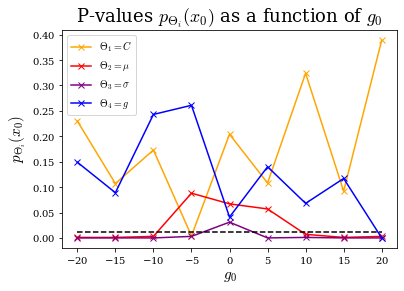

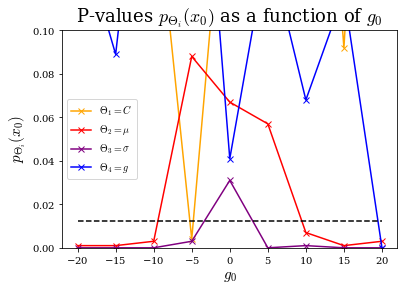

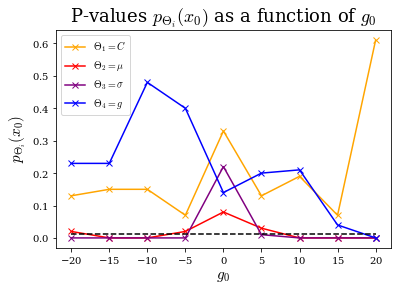

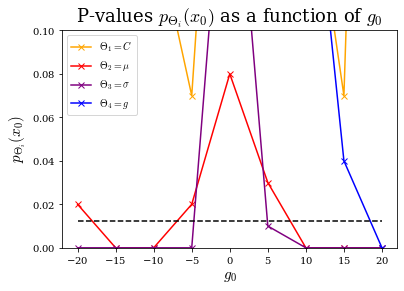

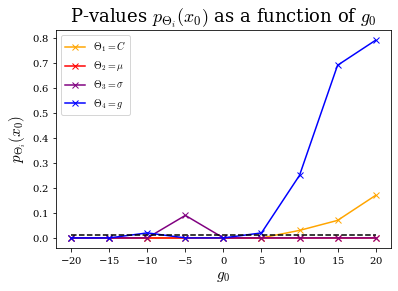

In [45]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

from diagnostics.multi_local_test import compute_test_statistic

colors=["orange", "red", "purple", "blue"]
labels = [r'$\Theta_1 = C$', r'$\Theta_2 = \mu$', r'$\Theta_3 = \sigma$', r'$\Theta_4 = g$']

gain_list = np.linspace(-20,20,9)

# HISTGRAD 
for i in range(1,5):
    plt.plot(gain_list, df_hg_t1000_na21_ns['p_values'][f'dim_{i}'], marker='x', label=labels[i-1], color=colors[i-1])
plt.legend()
plt.plot(gain_list,np.ones_like(gain_list)*0.0125, '--', color='black')
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$p_{\Theta_i}(x_0)$', fontsize=15)
plt.title(r'P-values $p_{\Theta_i}(x_0)$ as a function of $g_0$', fontsize=18)
plt.show()

# Zoom
for i in range(1,5):
    plt.plot(gain_list, df_hg_t1000_na21_ns['p_values'][f'dim_{i}'], marker='x', label=labels[i-1], color=colors[i-1])
plt.legend()
plt.plot(gain_list,np.ones_like(gain_list)*0.0125, '--', color='black')
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylim(0,0.1)
plt.ylabel(r'$p_{\Theta_i}(x_0)$', fontsize=15)
plt.title(r'P-values $p_{\Theta_i}(x_0)$ as a function of $g_0$', fontsize=18)
plt.show()

# HISTGRAD NM
for i in range(1,5):
    plt.plot(gain_list, df_hg_t100_na21_ns_nm['p_values'][f'dim_{i}'], marker='x', label=labels[i-1], color=colors[i-1])
plt.legend()
plt.plot(gain_list,np.ones_like(gain_list)*0.0125, '--', color='black')
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$p_{\Theta_i}(x_0)$', fontsize=15)
plt.title(r'P-values $p_{\Theta_i}(x_0)$ as a function of $g_0$', fontsize=18)
plt.show()

# Zoom
for i in range(1,5):
    plt.plot(gain_list, df_hg_t100_na21_ns_nm['p_values'][f'dim_{i}'], marker='x', label=labels[i-1], color=colors[i-1])
plt.legend()
plt.plot(gain_list,np.ones_like(gain_list)*0.0125, '--', color='black')
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylim(0,0.1)
plt.ylabel(r'$p_{\Theta_i}(x_0)$', fontsize=15)
plt.title(r'P-values $p_{\Theta_i}(x_0)$ as a function of $g_0$', fontsize=18)
plt.show()

# BASELINE
for i in range(1,5):
    plt.plot(gain_list, df_base_t100_na21_ns['p_values'][f'dim_{i}'], marker='x', label=labels[i-1], color=colors[i-1])
plt.plot(gain_list,np.ones_like(gain_list)*0.0125, '--', color='black')
plt.legend()
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$p_{\Theta_i}(x_0)$', fontsize=15)
plt.title(r'P-values $p_{\Theta_i}(x_0)$ as a function of $g_0$', fontsize=18)
plt.show()


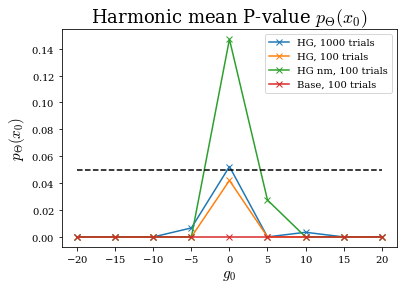

In [37]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

gain_list = np.linspace(-20,20,9)

# HISTGRAD 
plt.plot(gain_list, df_hg_t1000_na21_ns['p_values']['hmean'], marker='x', label='HG, 1000 trials')
plt.plot(gain_list, df_hg_t100_na21_ns['p_values']['hmean'], marker='x', label='HG, 100 trials')
plt.plot(gain_list, df_hg_t100_na21_ns_nm['p_values']['hmean'], marker='x', label='HG nm, 100 trials')
plt.plot(gain_list, df_base_t100_na21_ns['p_values'][f'hmean'], marker='x', label='Base, 100 trials')
plt.legend()
plt.plot(gain_list,np.ones_like(gain_list)*0.05, '--', color='black')
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$p_{\Theta}(x_0)$', fontsize=15)
plt.title(r'Harmonic mean P-value $p_{\Theta}(x_0)$', fontsize=18)
plt.show()

##### Plot Multi-Test results (not hmean)

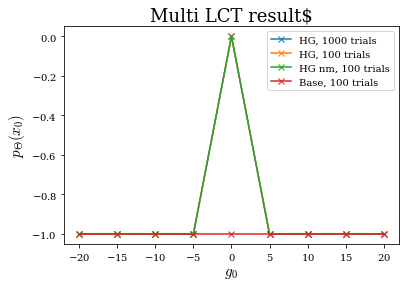

In [41]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

gain_list = np.linspace(-20,20,9)

# HISTGRAD 
plt.plot(gain_list, df_hg_t1000_na21_ns['lct_results']['combined']*-1, marker='x', label='HG, 1000 trials')
plt.plot(gain_list, df_hg_t100_na21_ns['lct_results']['combined']*-1, marker='x', label='HG, 100 trials')
plt.plot(gain_list, df_hg_t100_na21_ns_nm['lct_results']['combined']*-1, marker='x', label='HG nm, 100 trials')
plt.plot(gain_list, df_base_t100_na21_ns['lct_results']['combined']*-1, marker='x', label='Base, 100 trials')
plt.legend()
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$p_{\Theta}(x_0)$', fontsize=15)
plt.title(r'Multi LCT result$', fontsize=18)
plt.show()

#### Option two: PCA Image

##### Generate test observations $x_0$ 


In [24]:
# # ground-truth parameters to generate observation
# theta_obs, x_obs = simulate_for_sbi(
#         simulator=simulator, proposal=prior, num_simulations=20
# )
# x_obs = summary_extractor(x_obs)
# torch.save([theta_obs,x_obs], PATH_EXPERIMENT+'gt_observations/nextra_0/pca_experiment_new.pkl')
x_obs = torch.load(PATH_EXPERIMENT+'gt_observations/nextra_0/pca_experiment_new.pkl')[1]

# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca.fit(x_obs[:,:,0]) 
# x_new = pca.transform(x_obs[:,:,0])
# plt.scatter(x_new[:,0],x_new[:,1], color='blue')

##### Compute and combine p-values

0


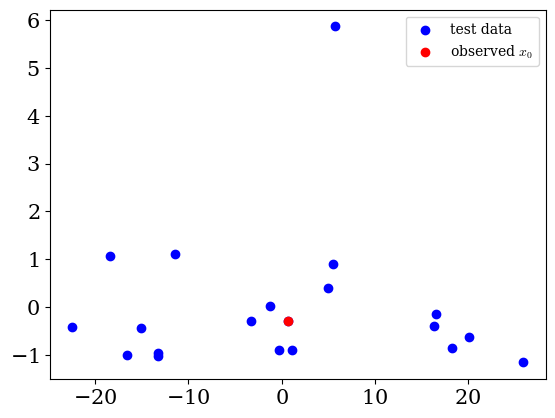

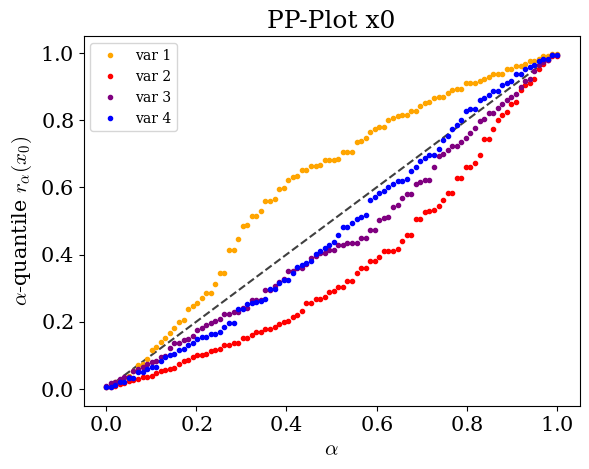

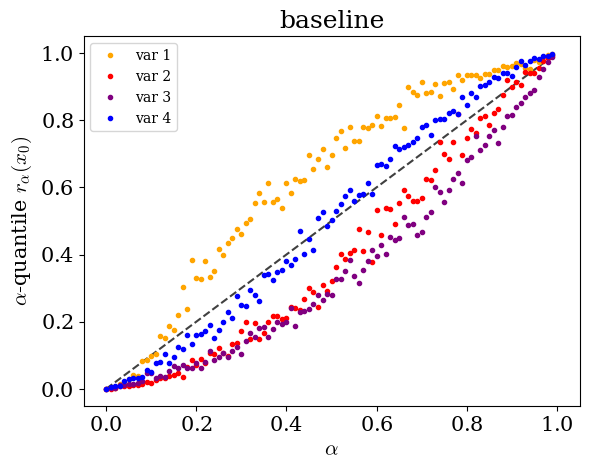

1


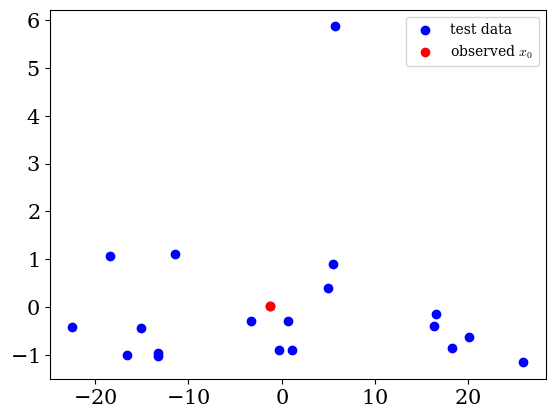

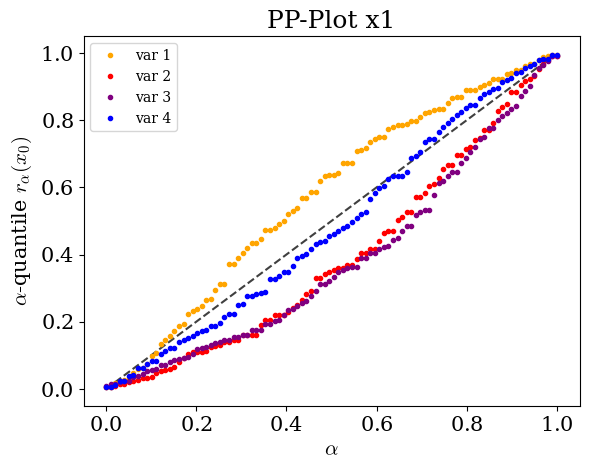

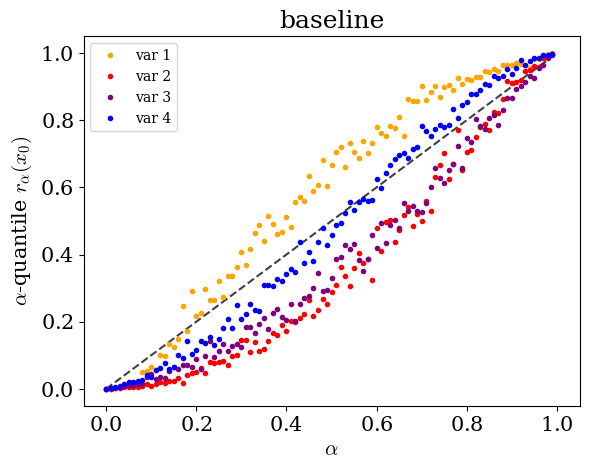

2


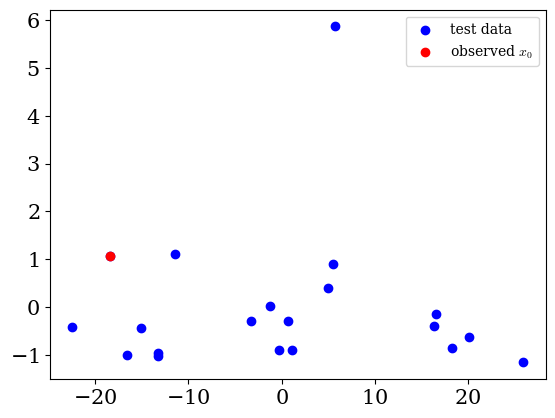

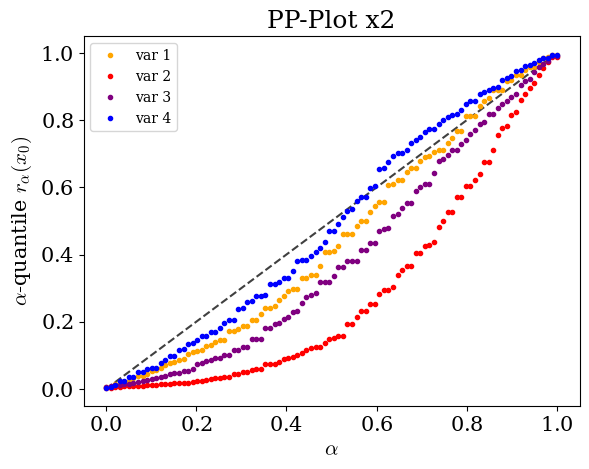

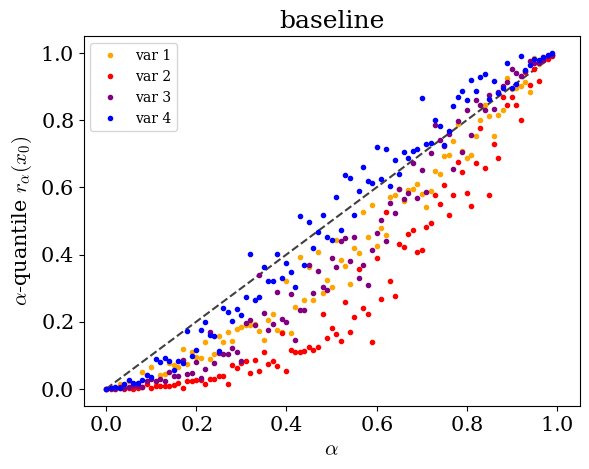

3


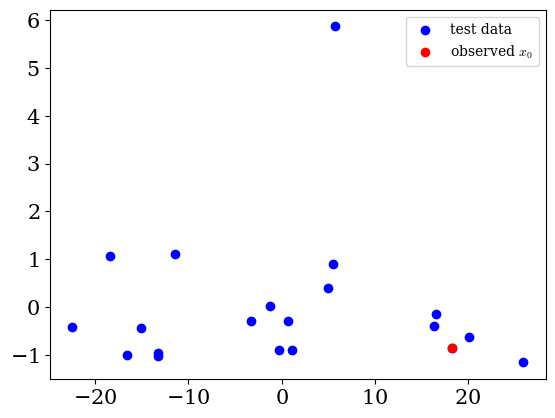

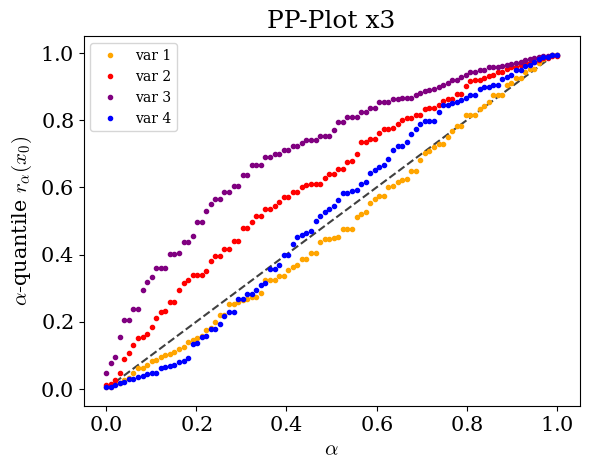

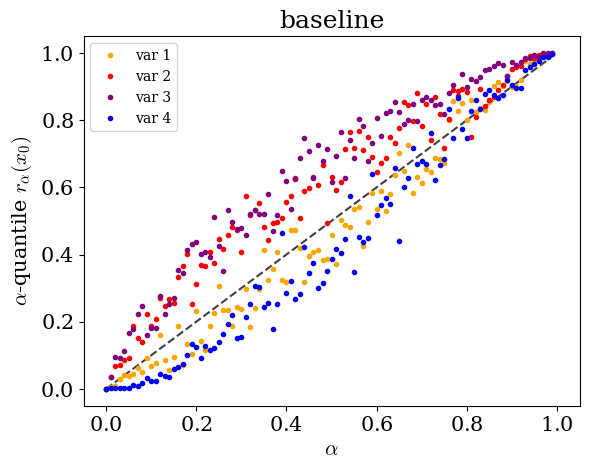

4


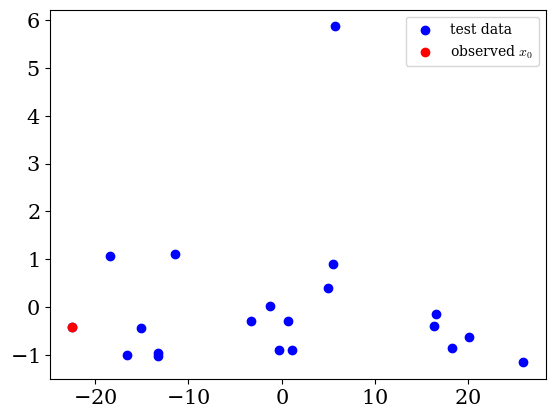

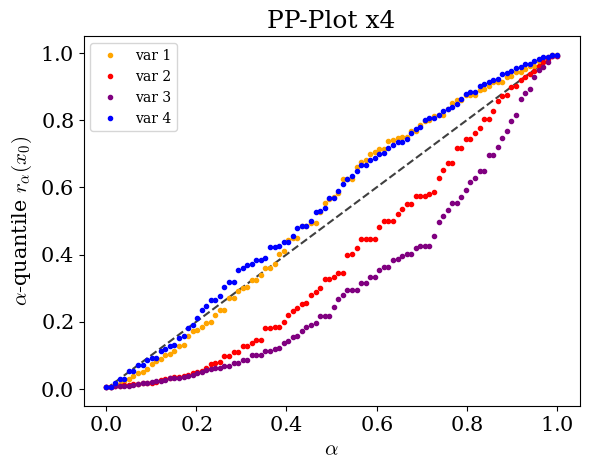

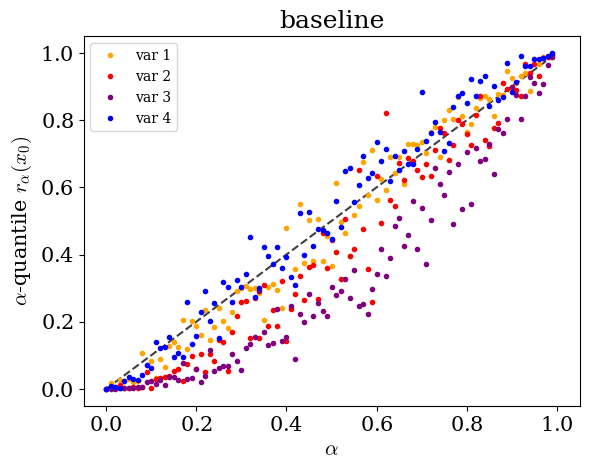

5


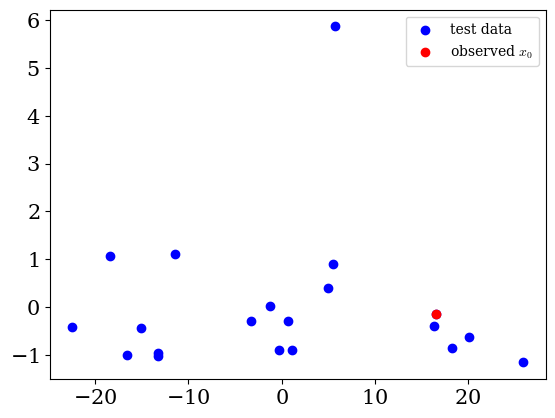

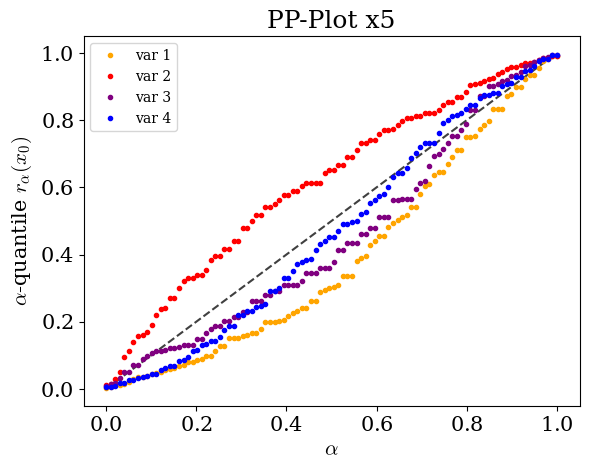

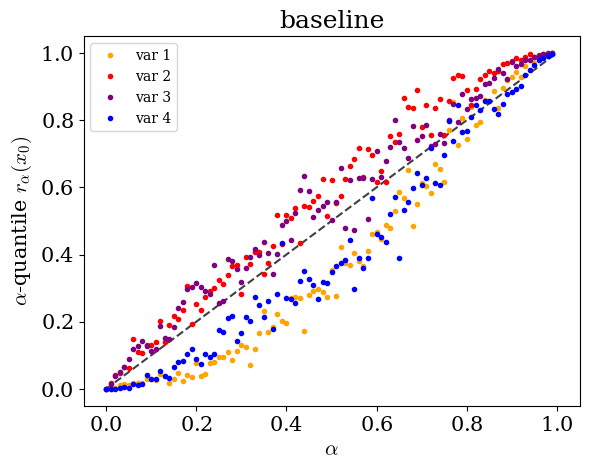

6


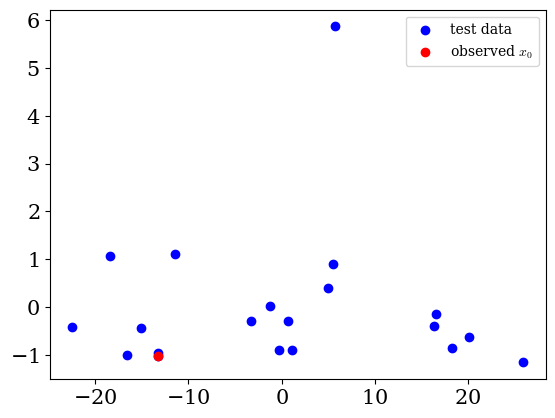

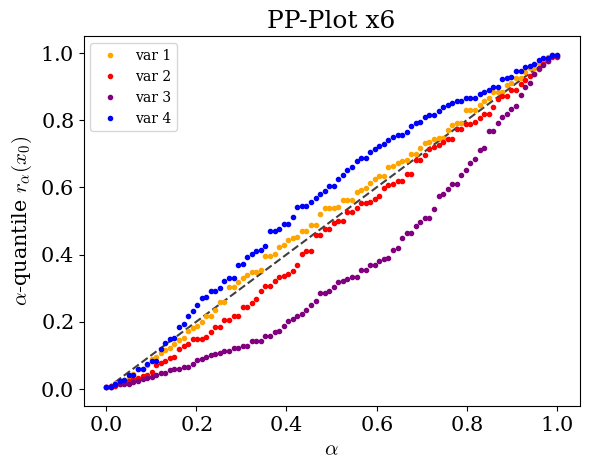

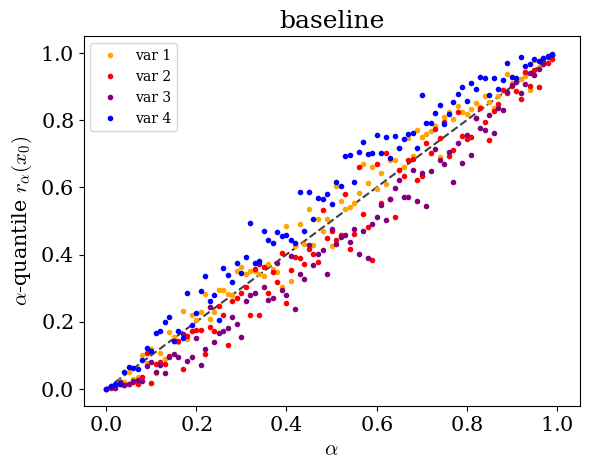

7


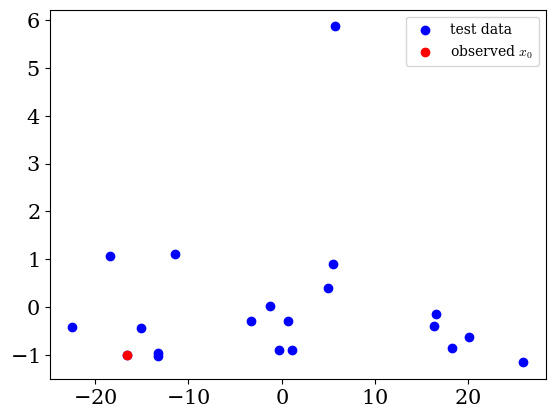

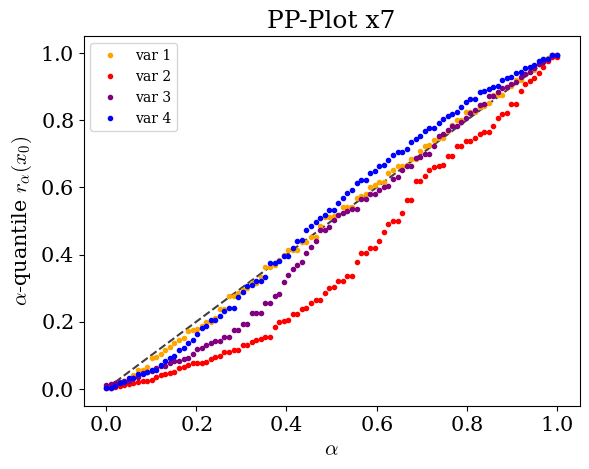

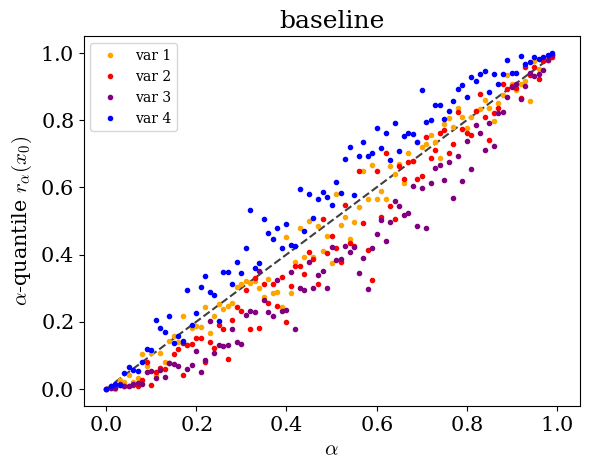

8


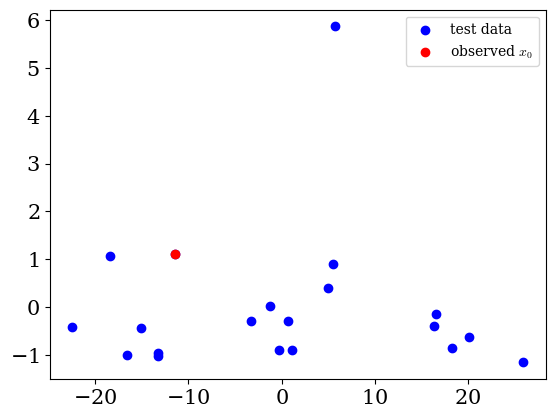

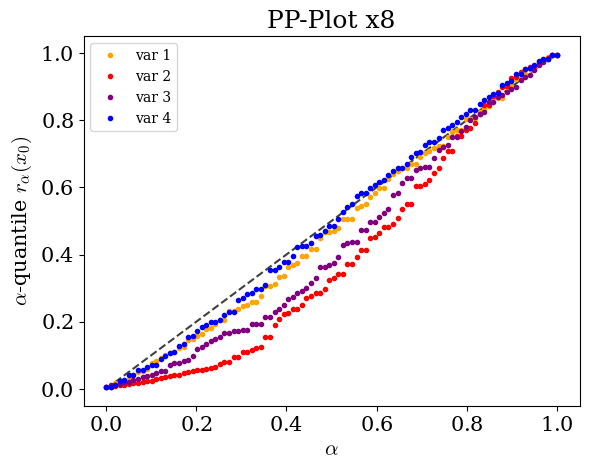

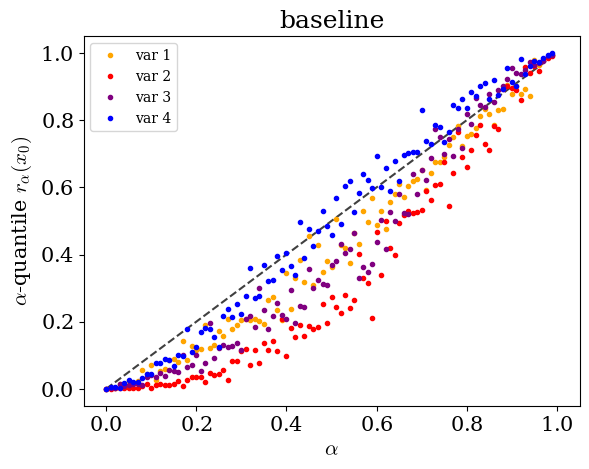

9


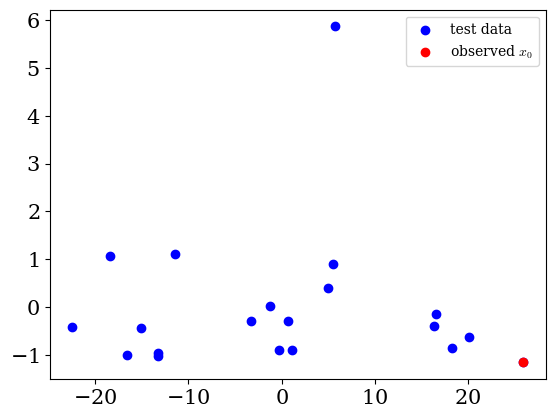

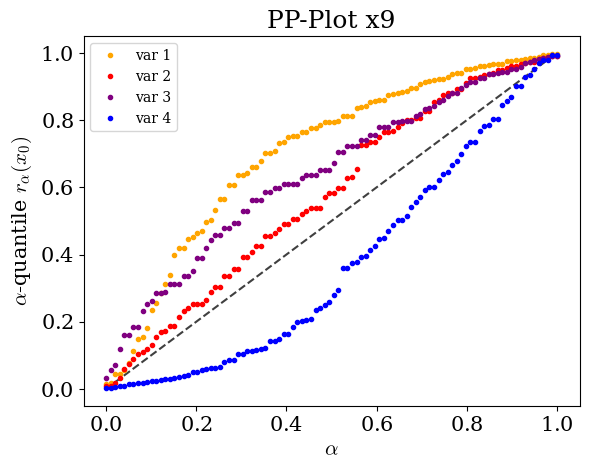

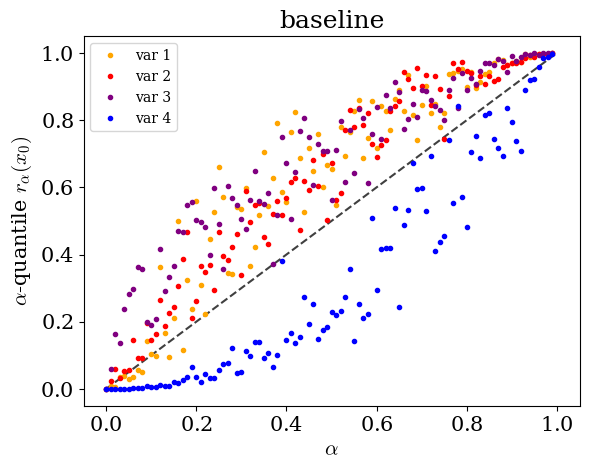

10


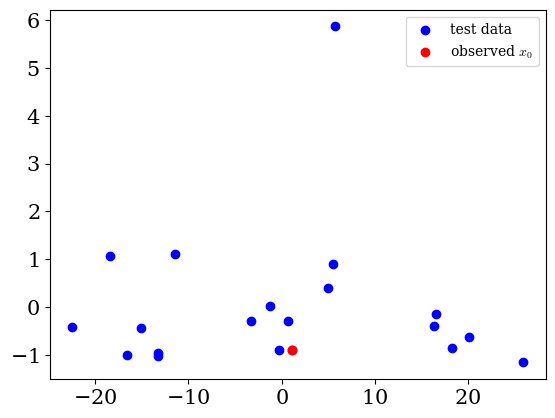

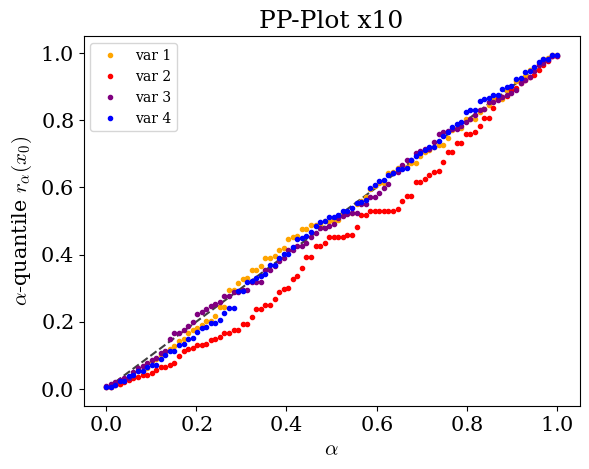

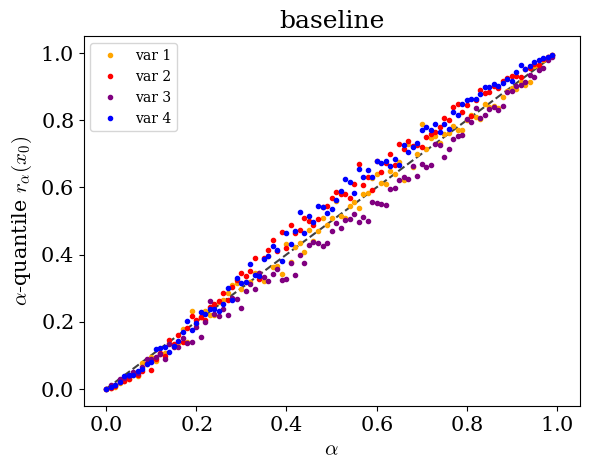

11


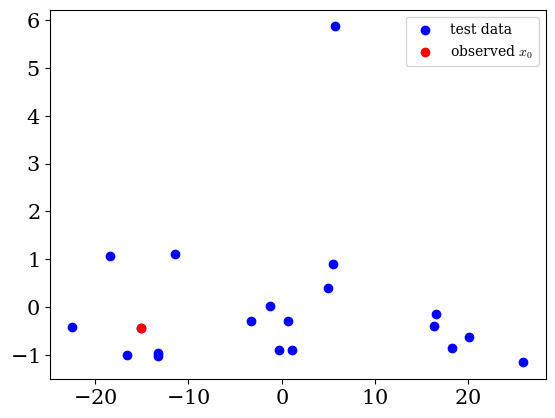

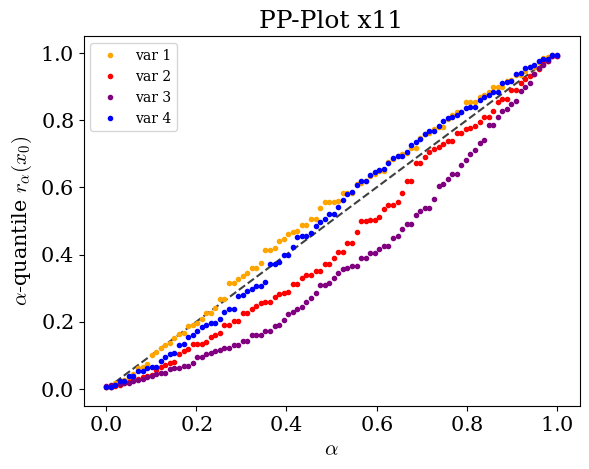

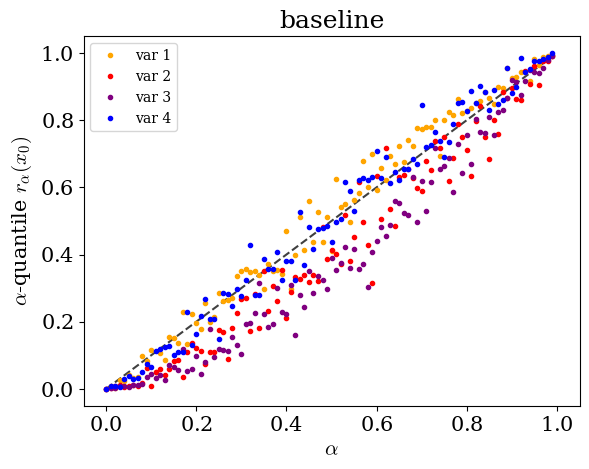

12


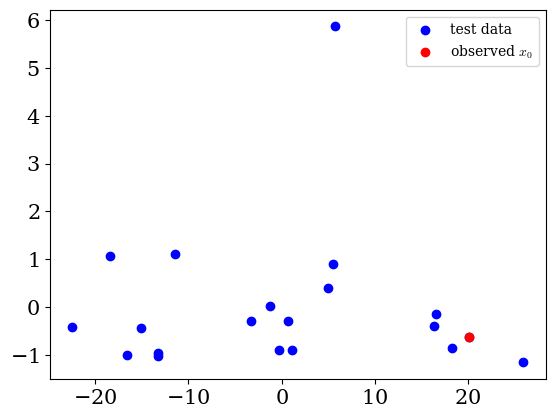

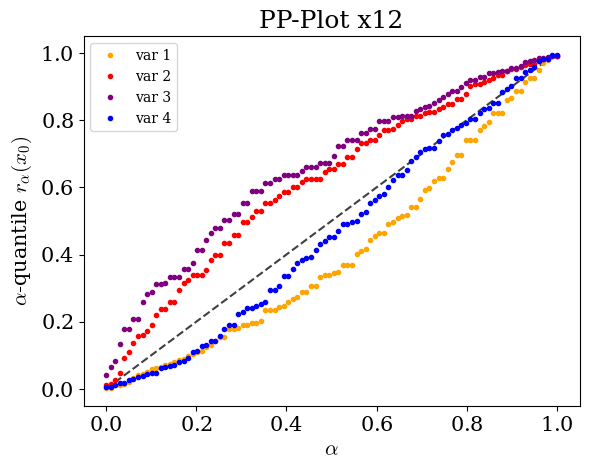

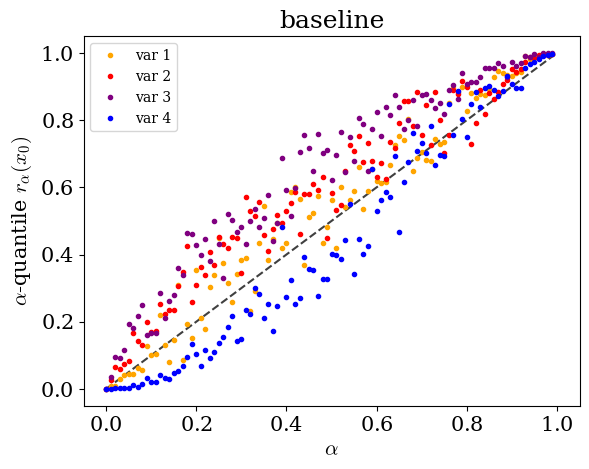

13


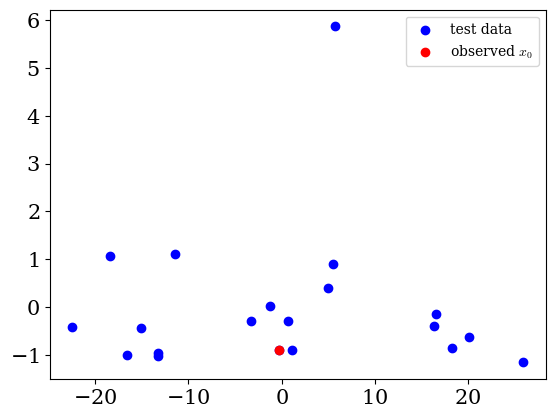

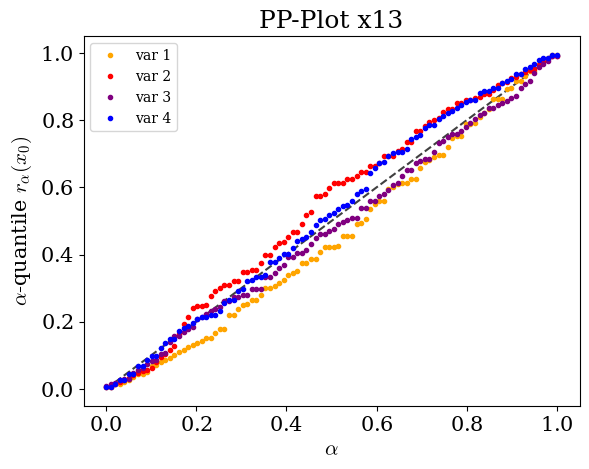

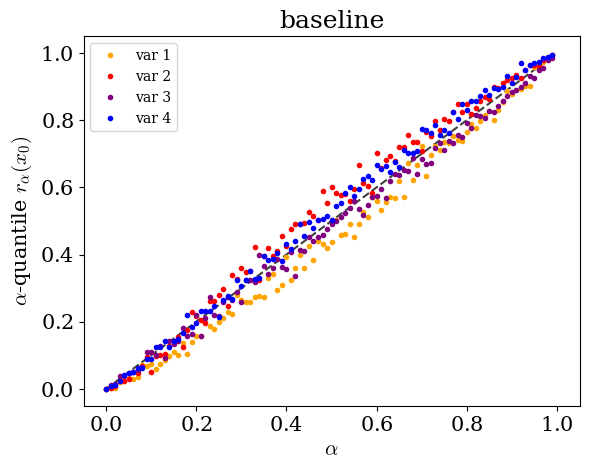

14


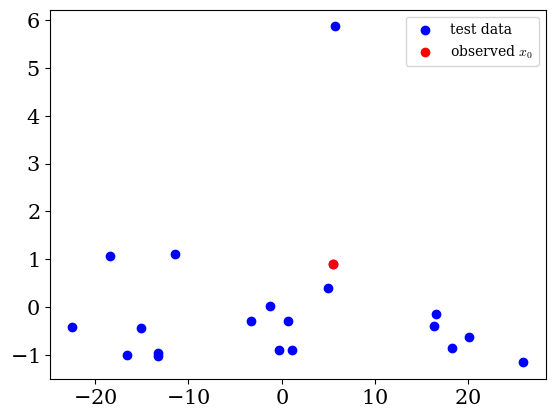

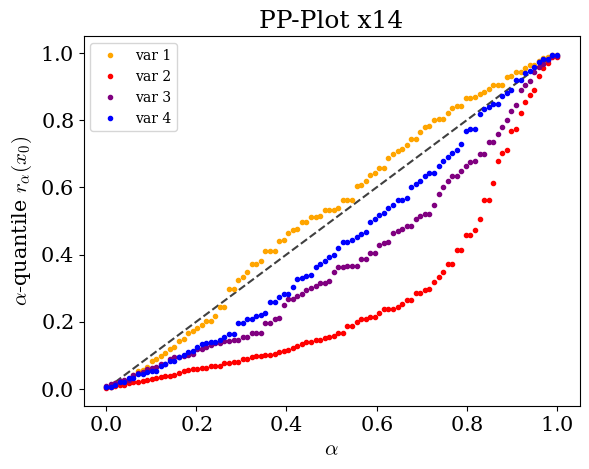

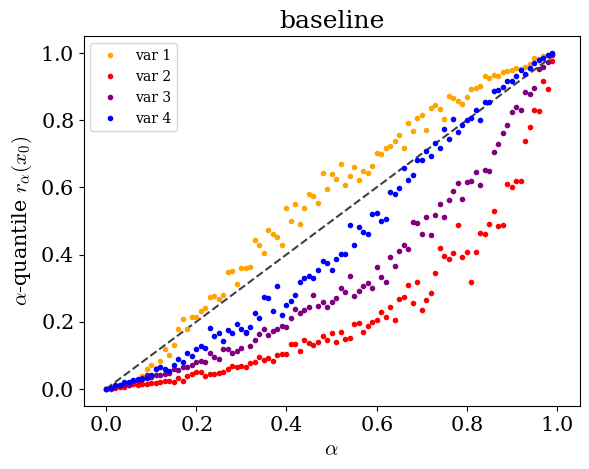

15


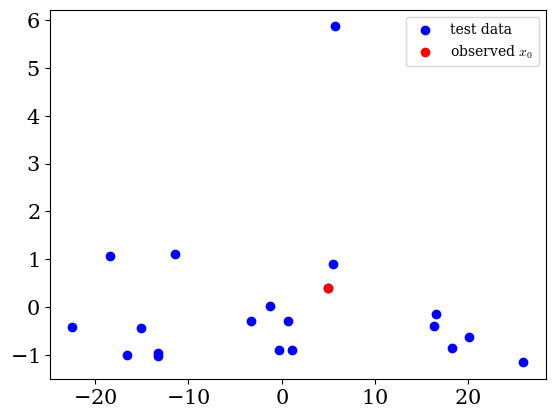

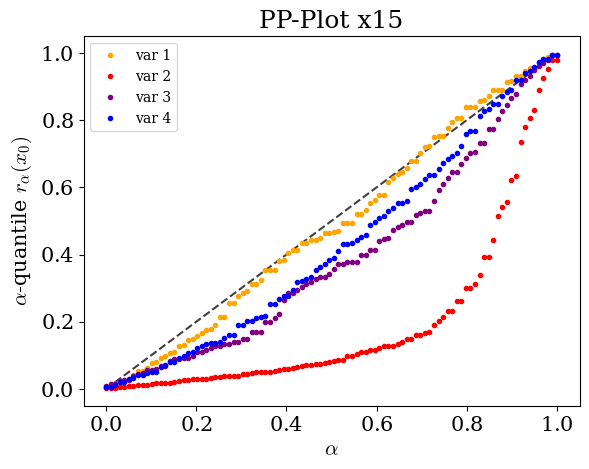

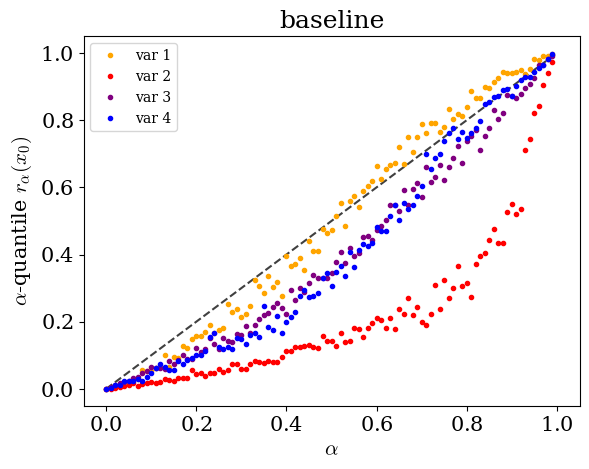

16


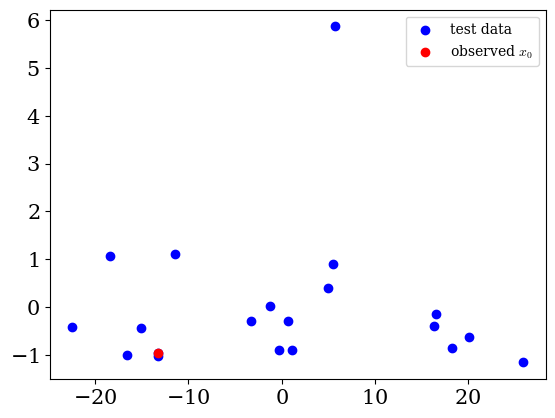

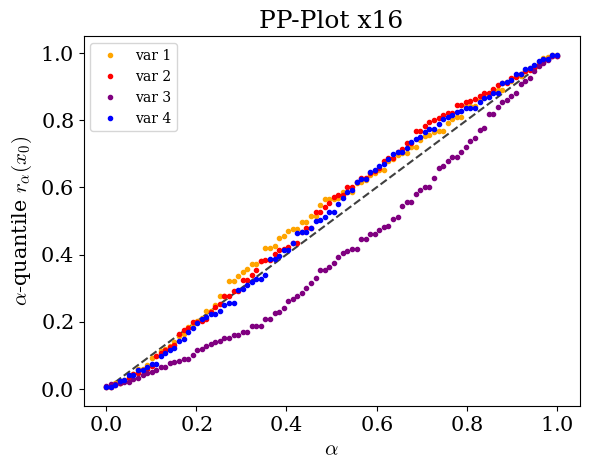

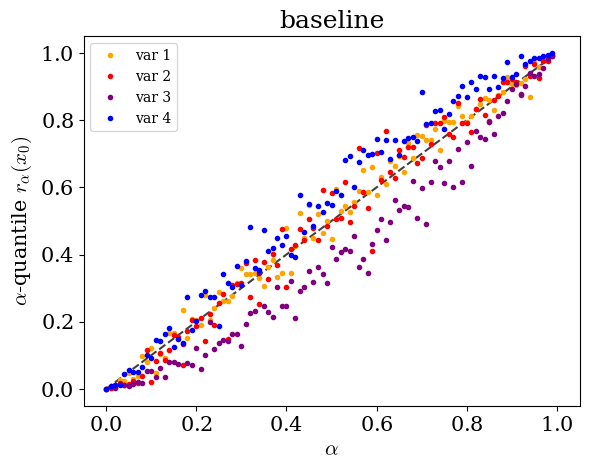

17


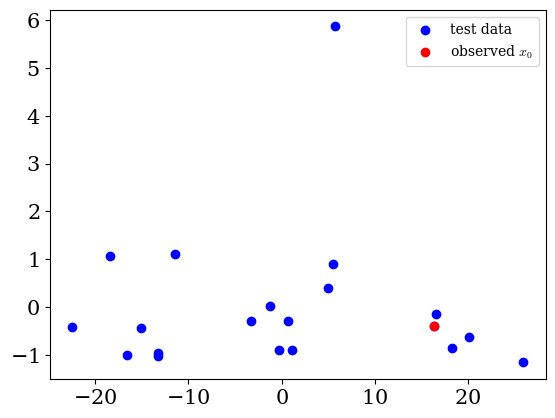

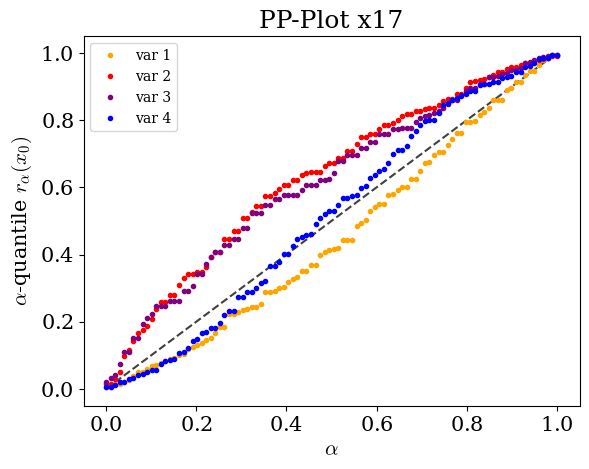

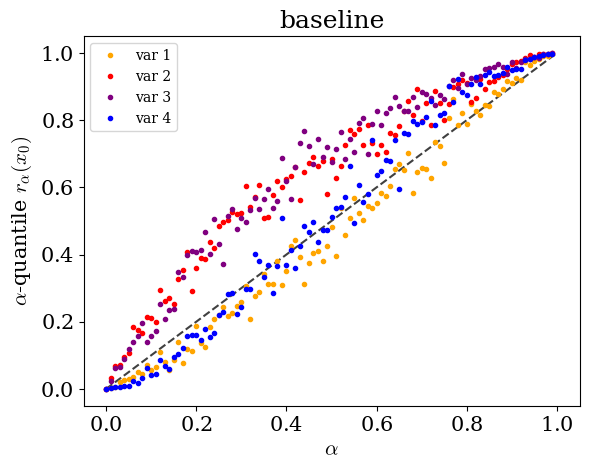

18


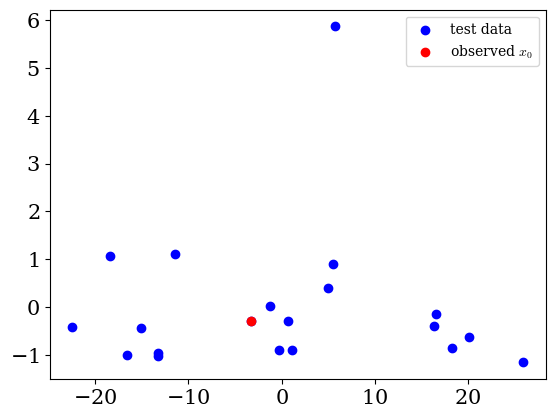

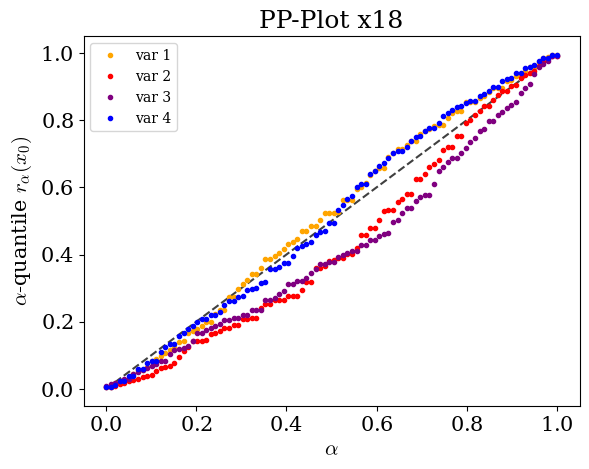

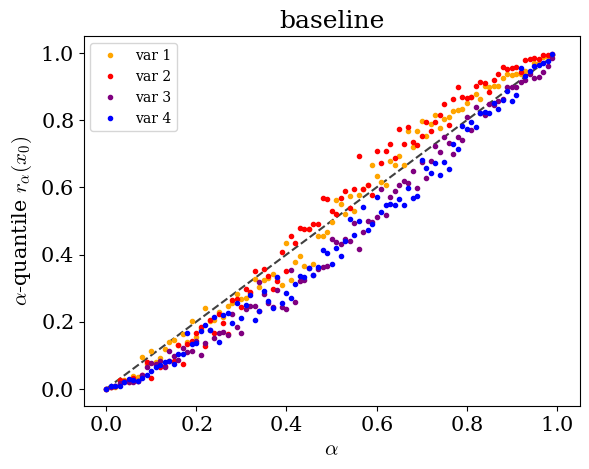

19


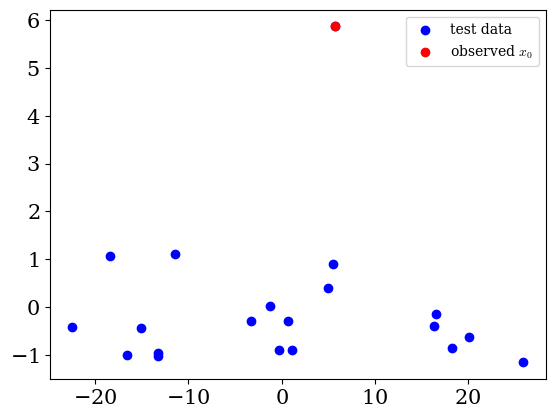

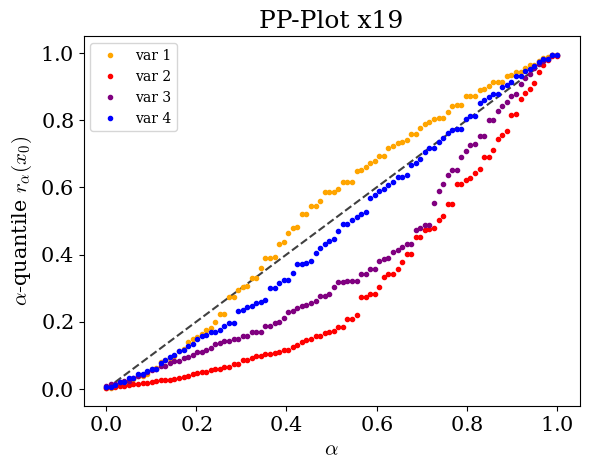

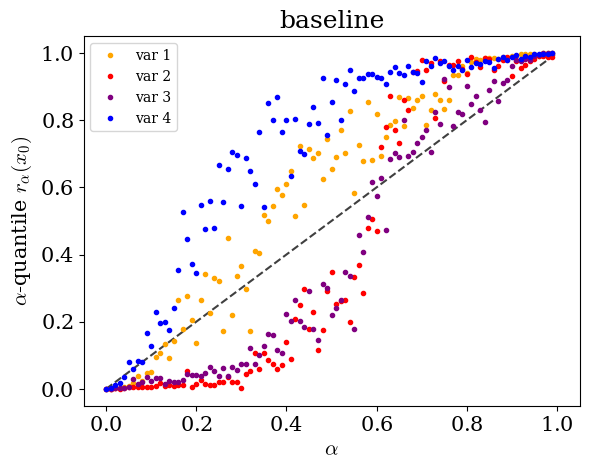

In [28]:
from scipy.stats import combine_pvalues
from sklearn.decomposition import PCA


ntrials = 1000
# path_lct = PATH_EXPERIMENT + f"pvalues/naive_nextra_{N_EXTRA}_nsim_{50000}/lct_results_ntrails_{ntrials}_n_alphas_{21}"
# path_lct_hg = PATH_EXPERIMENT + f"pvalues/naive_nextra_{N_EXTRA}_nsim_{50000}/lct_results_histgrad90_ntrails_{ntrials}_n_alphas_{21}"
# path_r_alpha = PATH_EXPERIMENT + f"r_alpha_learned/r_alpha_learned_{METHOD}_nextra_{N_EXTRA}_single_rec_{SINGLE_REC}_nsim_{B}"
# path_r_alpha_hg = PATH_EXPERIMENT + f"r_alpha_learned/r_alpha_learned_histgrad90_{METHOD}_nextra_{N_EXTRA}_nsim_{B}"

# path_lct_hg_new = PATH_EXPERIMENT+f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/lct_results_sample50_histgrad90_ntrials_{ntrials}_n_alphas_{100}"
# path_lct_baseline = PATH_EXPERIMENT+f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/lct_results_baseline_mlp_nalpha_100_ntrials_{ntrials}_n_alphas_{100}"

k_list = [19,18,15,14,13,10,9,17]
pca = PCA(n_components=2)
pca.fit(x_obs[:,:,0]) 
x_new = pca.transform(x_obs[:,:,0])
# plt.scatter(x_new[:,0],x_new[:,1], color='blue')

combined_pvalues = []
combined_pvalues_hg = []
for dim in range(1,5):
    for k in range(20):
        # pvalues = torch.load(path_lct+f"_pca_x{k}_new.pkl")['pvalues']
        # lct_hg = torch.load(path_lct_hg+f"_pca_x{k}_new.pkl")
        # pvalues_hg, r_alpha, r_alpha_null_list = lct_hg['pvalues'], lct_hg['r_alpha_learned'], lct_hg['r_alpha_null_list']

        lct_hg = torch.load(path_lct_hg+f"_pca_x{k}.pkl")
        lct_baseline = torch.load(path_lct_baseline+f"_pca_x{k}.pkl")
        
        # pvalues_hg, r_alpha, r_alpha_null_list = lct_hg['pvalues'], lct_hg['r_alpha_learned'], lct_hg['r_alpha_null_list']
        r_alpha = lct_hg['r_alpha_learned']
        r_alpha_baseline = lct_baseline['r_alpha_learned']
        if dim ==1:

            # COMBINED p-VALUES
            # combined_pvalues.append(combine_pvalues(list(pvalues.values()))[1])
            # combined_pvalues_hg.append(combine_pvalues(list(pvalues_hg.values()))[1])
            print(k)
            # print(f'pvalues = {pvalues_hg}')
            # print(combined_pvalues[-1])
            # print(combined_pvalues_hg[-1])

            # PCA PLOT 
            x_new_k = x_new[k]
            fig, ax = plt.subplots()
            ax.scatter(x_new[:,0],x_new[:,1], color='blue', label='test data')
            ax.scatter(x_new_k[0],x_new_k[1], color='red', label=r'observed $x_0$')
            # ax.annotate(f'pvalue = {combined_pvalues_hg[-1]}', (x_new_k[0], x_new_k[1]))
            plt.legend()
            # plt.title(f'pvalue = {combined_pvalues_hg[-1]}')
            plt.show()

            PP_plot_1D(
                PIT_values=None,
                alphas=np.linspace(0, 1, 100),
                r_alpha_learned=[
                    r_alpha["dim_1"],
                    r_alpha["dim_2"],
                    r_alpha["dim_3"],
                    r_alpha["dim_4"],
                ],
                colors=["orange", "red"],
                colors_r_alpha=["orange", "red", "purple", "blue"],
                labels=["var 1", "var 2", "var 3", "var 4"],
                title=f"PP-Plot x{k}",
            )

            # # for null hypothesis
            # PP_plot_1D(
            #     PIT_values=None,
            #     alphas=np.linspace(0, 1, 21),
            #     r_alpha_learned=[
            #         r_alpha_null_list[50]["dim_1"],
            #         r_alpha_null_list[50]["dim_2"],
            #         r_alpha_null_list[50]["dim_3"],
            #         r_alpha_null_list[50]["dim_4"],
            #     ],
            #     colors=["orange", "red"],
            #     colors_r_alpha=["orange", "red", "purple", "blue"],
            #     labels=["var 1", "var 2", "var 3", "var 4"],
            #     title=f"pvalues = {pvalues_hg}",
            # )

            # PP-PLOT BASELINE
            # on grid
            # r_alpha_learned = torch.load(path_r_alpha+f"_pca_x{k}_new.pkl")
            PP_plot_1D(
                PIT_values=None,
                alphas=np.linspace(0, 0.99, 100),
                r_alpha_learned=[
                    r_alpha_baseline["dim_1"],
                    r_alpha_baseline["dim_2"],
                    r_alpha_baseline["dim_3"],
                    r_alpha_baseline["dim_4"],
                ],
                colors=["orange", "red"],
                colors_r_alpha=["orange", "red", "purple", "blue"],
                labels=["var 1", "var 2", "var 3", "var 4"],
                title=f"baseline",
            )

